In [49]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import mlflow
import mlflow.sklearn
import tempfile
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Execise 1

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and then use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

### 1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.

In [4]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Bobby\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [8]:
dataset_path = "C:/Users/Bobby/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv']


In [9]:
file_path = "C:/Users/Bobby/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [10]:
df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [11]:
%run mlflow_startup_interface.ipynb # it won't let me import it

In [83]:
start_mlflow()


Starting MLFlow UI...


[Open MLFlow UI](http://localhost:5000)

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.


In [13]:
df

PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0
...                      ...
2018-08-02 20:00:00  44057.0
2018-08-02 21:00:00  43256.0
2018-08-02 22:00:00  41552.0
2018-08-02 23:00:00  38500.0
2018-08-03 00:00:00  35486.0

[145366 rows x 1 columns]

### 2. Setup a nested MLFlow loop where different modelling experiments can be tracked and then use the dataset in point 1 to experiment and track models. You should do following combinations:

    At least 3 model types
    At least 3 different feature combinations
    At least 3 different options for 3 different hyperparameters
    At least 3 different time splits for train test


In [ ]:
def create_features(df):
    #Create time series features and lag features based on time series index.
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df = create_features(df)

In [15]:
df = df.dropna()

In [16]:
df

PJME_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                              
2002-01-17 11:00:00  34115.0    11          3        1      1  2002   
2002-01-17 12:00:00  33835.0    12          3        1      1  2002   
2002-01-17 13:00:00  33368.0    13          3        1      1  2002   
2002-01-17 14:00:00  33152.0    14          3        1      1  2002   
2002-01-17 15:00:00  32662.0    15          3        1      1  2002   
...                      ...   ...        ...      ...    ...   ...   
2018-08-02 20:00:00  44057.0    20          3        3      8  2018   
2018-08-02 21:00:00  43256.0    21          3        3      8  2018   
2018-08-02 22:00:00  41552.0    22          3        3      8  2018   
2018-08-02 23:00:00  38500.0    23          3        3      8  2018   
2018-08-03 00:00:00  35486.0     0          4        3      8  2018   

                     dayofyear  dayofmonth  weekofyear   lag_1d   lag_1w  \
Datetime                                                                   
2002-01-17 11:00:00         17          17           3  34638.0  25708.0   
2002-01-17 12:00:00         17          17           3  34115.0  26130.0   
2002-01-17 13:00:00         17          17           3  33835.0  28123.0   
2002-01-17 14:00:00         17          17           3  33368.0  32359.0   
2002-01-17 15:00:00         17          17           3  33152.0  34860.0   
...                        ...         ...         ...      ...      ...   
2018-08-02 20:00:00        214           2          31  45641.0  45372.0   
2018-08-02 21:00:00        214           2          31  44057.0  46534.0   
2018-08-02 22:00:00        214           2          31  43256.0  47154.0   
2018-08-02 23:00:00        214           2          31  41552.0  46989.0   
2018-08-03 00:00:00        215           3          31  38500.0  46816.0   

                      lag_1m   lag_1y  rolling_mean_3d  rolling_mean_30d  \
Datetime                                                                   
2002-01-17 11:00:00  26174.0  30748.0     34485.333333      32294.733333   
2002-01-17 12:00:00  28361.0  34725.0     34196.000000      32477.200000   
2002-01-17 13:00:00  32443.0  37313.0     33772.666667      32508.033333   
2002-01-17 14:00:00  34902.0  37322.0     33451.666667      32449.700000   
2002-01-17 15:00:00  34752.0  37035.0     33060.666667      32380.033333   
...                      ...      ...              ...               ...   
2018-08-02 20:00:00  45313.0  42771.0     45486.000000      41515.666667   
2018-08-02 21:00:00  46430.0  43742.0     44318.000000      41409.866667   
2018-08-02 22:00:00  47867.0  44607.0     42955.000000      41199.366667   
2018-08-02 23:00:00  48855.0  45057.0     41102.666667      40854.200000   
2018-08-03 00:00:00  49308.0  44294.0     38512.666667      40393.466667   

                     rolling_mean_same_month_last_year  \
Datetime                                                 
2002-01-17 11:00:00                       30465.500000   
2002-01-17 12:00:00                       30609.900000   
2002-01-17 13:00:00                       30878.166667   
2002-01-17 14:00:00                       31177.000000   
2002-01-17 15:00:00                       31481.533333   
...                                                ...   
2018-08-02 20:00:00                       38934.233333   
2018-08-02 21:00:00                       38948.666667   
2018-08-02 22:00:00                       38906.000000   
2018-08-02 23:00:00                       38805.866667   
2018-08-03 00:00:00                       38629.466667   

                     rolling_mean_same_week_last_year  
Datetime                                               
2002-01-17 11:00:00                      28444.000000  
2002-01-17 12:00:00                      29181.428571  
2002-01-17 13:00:00                      30494.571429  
2002-01-17 14:00:00                      31906.714286  
2002-01-17 15:00:00         

In [ ]:
# Split the data
X = df.drop(columns = ["PJME_MW"])
y = df['PJME_MW']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

# Define different feature combinations
feature_combinations = [
    X.columns[:2],  # First two features
    X.columns[-2:], # Last two features
    X.columns[3:8]  # Feature 3-7
]

time_split = ['03-1-2002', '05-01-2002', '07-01-2002'] # train at home with higher values, m/d/y

In [18]:
X.index.min()

Timestamp('2002-01-17 11:00:00')

In [19]:
X.index.max()

Timestamp('2018-08-03 00:00:00')

In [74]:
X_fun = X[X.index.min():(X.index.min() + pd.Timedelta(days=30))]
X_fun

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-01-17 11:00:00    11          3        1      1  2002         17   
2002-01-17 12:00:00    12          3        1      1  2002         17   
2002-01-17 13:00:00    13          3        1      1  2002         17   
2002-01-17 14:00:00    14          3        1      1  2002         17   
2002-01-17 15:00:00    15          3        1      1  2002         17   
...                   ...        ...      ...    ...   ...        ...   
2002-02-16 07:00:00     7          5        1      2  2002         47   
2002-02-16 08:00:00     8          5        1      2  2002         47   
2002-02-16 09:00:00     9          5        1      2  2002         47   
2002-02-16 10:00:00    10          5        1      2  2002         47   
2002-02-16 11:00:00    11          5        1      2  2002         47   

                     dayofmonth  weekofyear   lag_1d   lag_1w   lag_1m  \
Datetime                                                                 
2002-01-17 11:00:00          17           3  34638.0  25708.0  26174.0   
2002-01-17 12:00:00          17           3  34115.0  26130.0  28361.0   
2002-01-17 13:00:00          17           3  33835.0  28123.0  32443.0   
2002-01-17 14:00:00          17           3  33368.0  32359.0  34902.0   
2002-01-17 15:00:00          17           3  33152.0  34860.0  34752.0   
...                         ...         ...      ...      ...      ...   
2002-02-16 07:00:00          16           7  24063.0  27196.0  28309.0   
2002-02-16 08:00:00          16           7  25333.0  25243.0  27354.0   
2002-02-16 09:00:00          16           7  26563.0  24250.0  26960.0   
2002-02-16 10:00:00          16           7  28413.0  23700.0  27001.0   
2002-02-16 11:00:00          16           7  29328.0  23364.0  27617.0   

                      lag_1y  rolling_mean_3d  rolling_mean_30d  \
Datetime                                                          
2002-01-17 11:00:00  30748.0     34485.333333      32294.733333   
2002-01-17 12:00:00  34725.0     34196.000000      32477.200000   
2002-01-17 13:00:00  37313.0     33772.666667      32508.033333   
2002-01-17 14:00:00  37322.0     33451.666667      32449.700000   
2002-01-17 15:00:00  37035.0     33060.666667      32380.033333   
...                      ...              ...               ...   
2002-02-16 07:00:00  23905.0     24291.666667      29946.900000   
2002-02-16 08:00:00  23443.0     25319.666667      29920.533333   
2002-02-16 09:00:00  23416.0     26769.666667      29968.966667   
2002-02-16 10:00:00  23932.0     28101.333333      30046.533333   
2002-02-16 11:00:00  25806.0     29056.333333      30106.900000   

                     rolling_mean_same_month_last_year  \
Datetime                                                 
2002-01-17 11:00:00                       30465.500000   
2002-01-17 12:00:00                       30609.900000   
2002-01-17 13:00:00                       30878.166667   
2002-01-17 14:00:00                       31177.000000   
2002-01-17 15:00:00                       31481.533333   
...                                                ...   
2002-02-16 07:00:00                       29832.033333   
2002-02-16 08:00:00                       29543.233333   
2002-02-16 09:00:00                       29311.400000   
2002-02-16 10:00:00                       29182.166667   
2002-02-16 11:00:00                       29197.966667   

                     rolling_mean_same_week_last_year  
Datetime                                               
2002-01-17 11:00:00                      28444.000000  
2002-01-17 12:00:00                      29181.428571  
2002-01-17 13:00:00                      30494.571429  
2002-01-17 14:00:00                      31906.714286  
2002-01-17 15:00:00                      33297.285714  
...                                               ...  
2002-02-16 07:00:00              

In [60]:
def create_actual_predict_plot(y_test, y_pred, model_name, features):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='dashed', alpha=0.5)

    plt.xticks(fontsize=10) # should potentionally transform the date to only show the day and hour, or display hours in increment hour1, hour2...
    
    plt.title(f"{model_name} Metrics for Feature Set: {features}")
    plt.xlabel('Hours')
    plt.ylabel('Bike count')
    plt.legend()
    
    return plt

DANGER!! DONT RUN ME AGAIN

2025/03/14 00:25:21 INFO mlflow.tracking.fluent: Experiment with name 'MLFlow Energy Consumption data' does not exist. Creating a new experiment.
2025/03/14 00:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/14 00:25:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/14 00:25:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\Bobby\anaconda3\envs\Python_3_10_16\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the dat


Summary of Experiment Results:
                                             features               model  \
0        Index(['hour', 'dayofweek'], dtype='object')        RandomForest   
1        Index(['hour', 'dayofweek'], dtype='object')        RandomForest   
2        Index(['hour', 'dayofweek'], dtype='object')        RandomForest   
3        Index(['hour', 'dayofweek'], dtype='object')  LogisticRegression   
4        Index(['hour', 'dayofweek'], dtype='object')  LogisticRegression   
5        Index(['hour', 'dayofweek'], dtype='object')  LogisticRegression   
6   Index(['rolling_mean_same_month_last_year', 'r...        RandomForest   
7   Index(['rolling_mean_same_month_last_year', 'r...        RandomForest   
8   Index(['rolling_mean_same_month_last_year', 'r...        RandomForest   
9   Index(['rolling_mean_same_month_last_year', 'r...  LogisticRegression   
10  Index(['rolling_mean_same_month_last_year', 'r...  LogisticRegression   
11  Index(['rolling_mean_same_month_last_yea

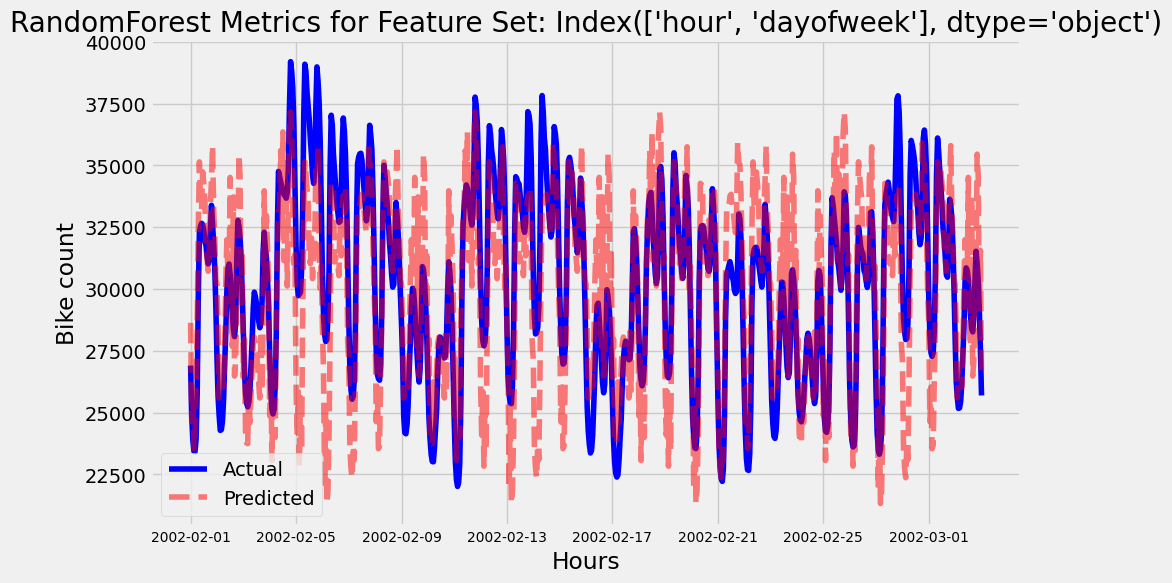

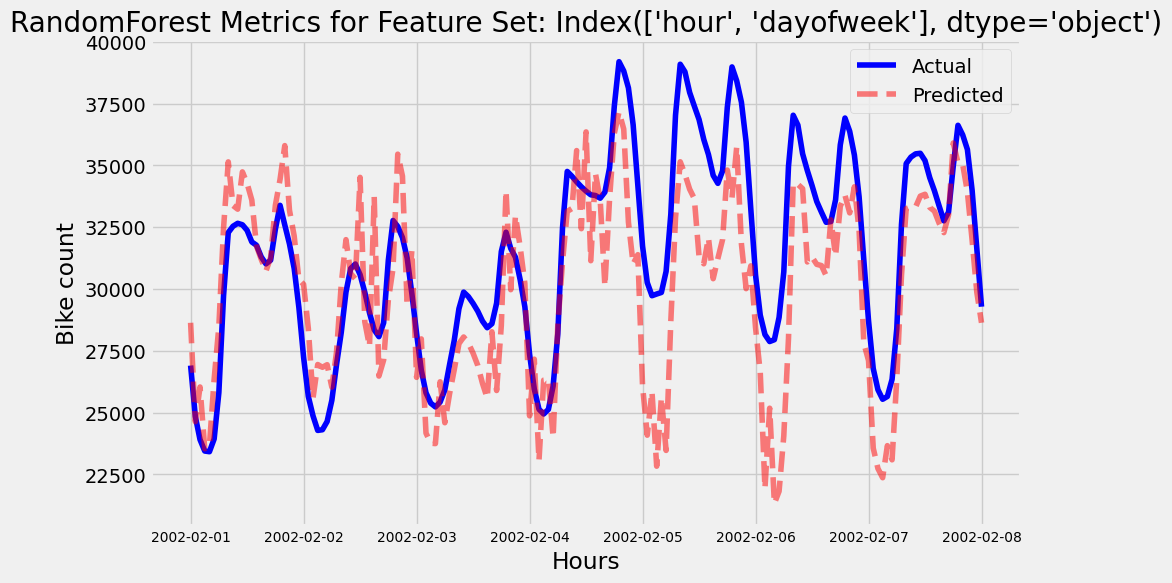

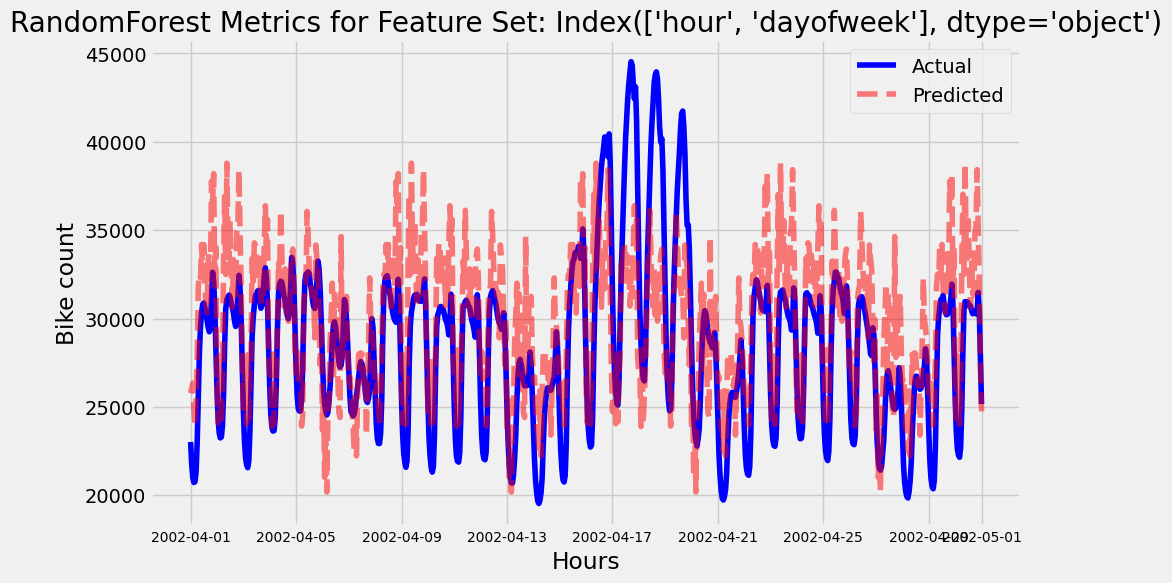

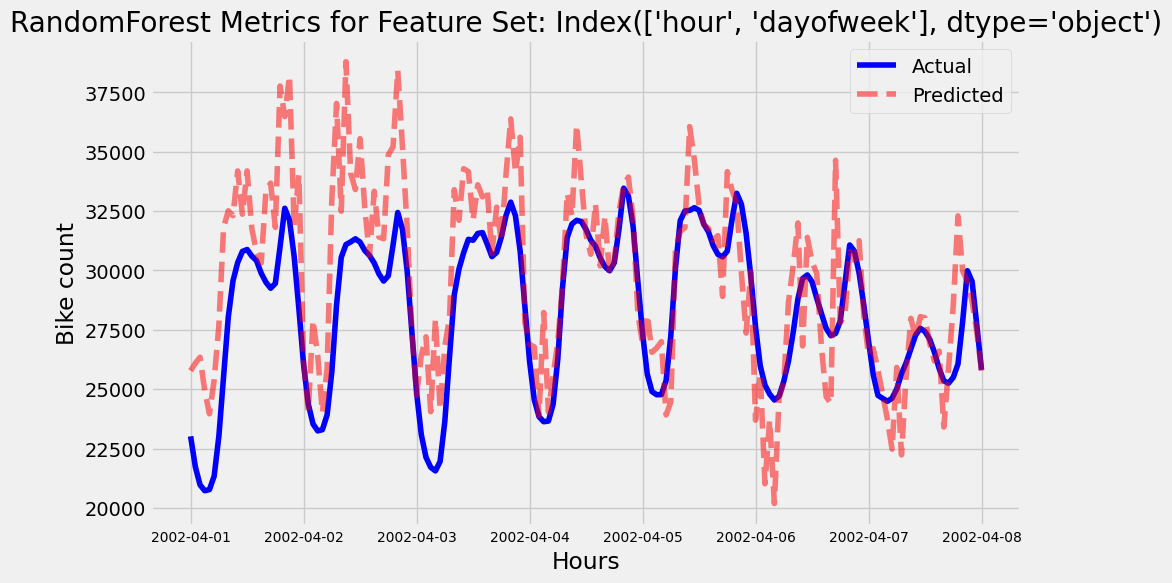

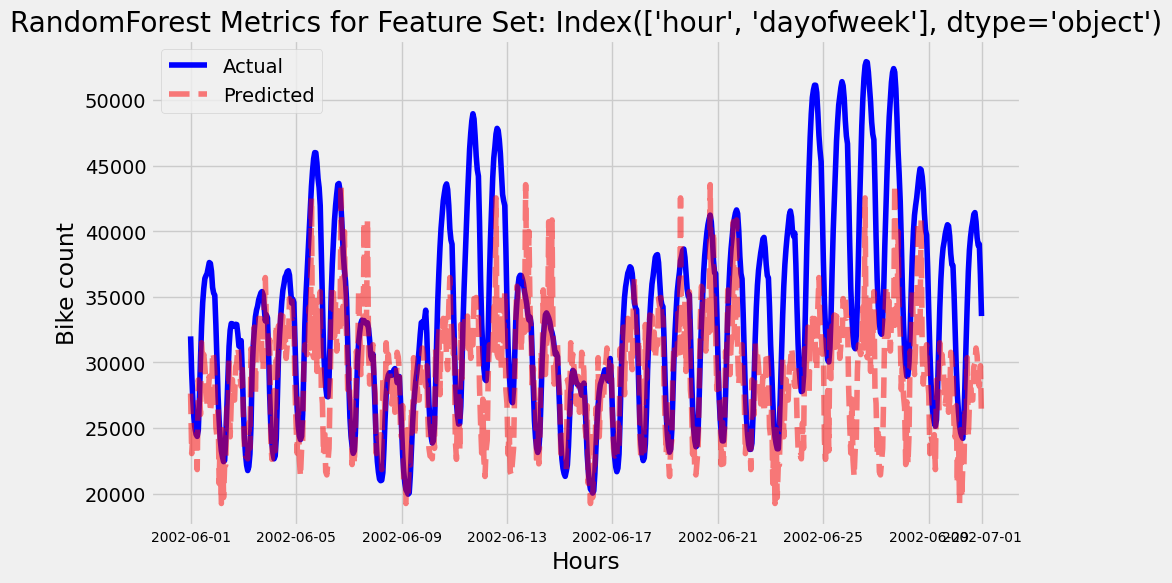

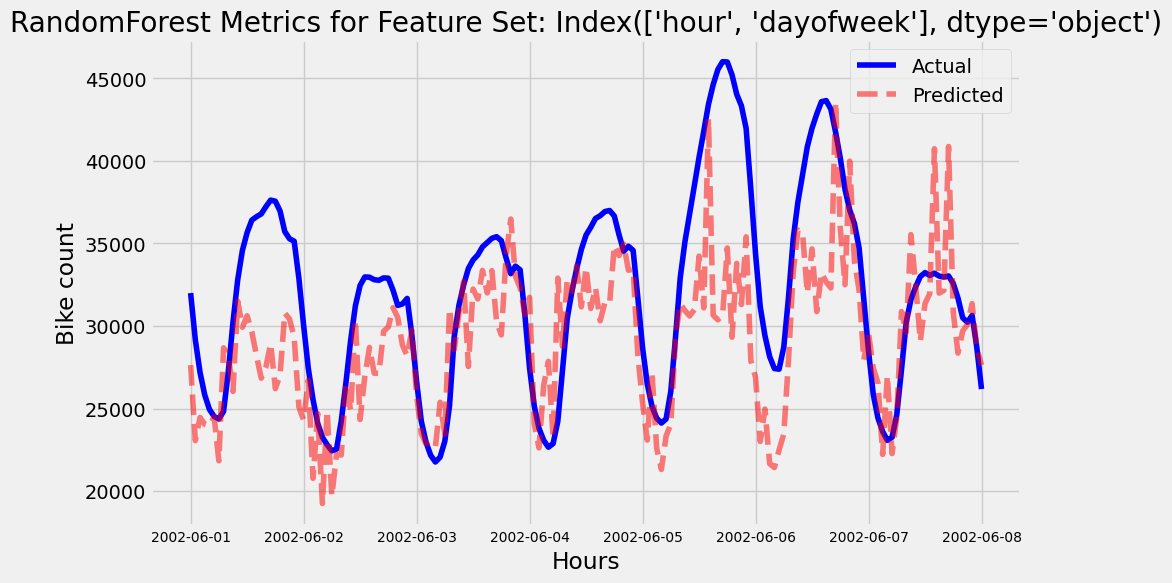

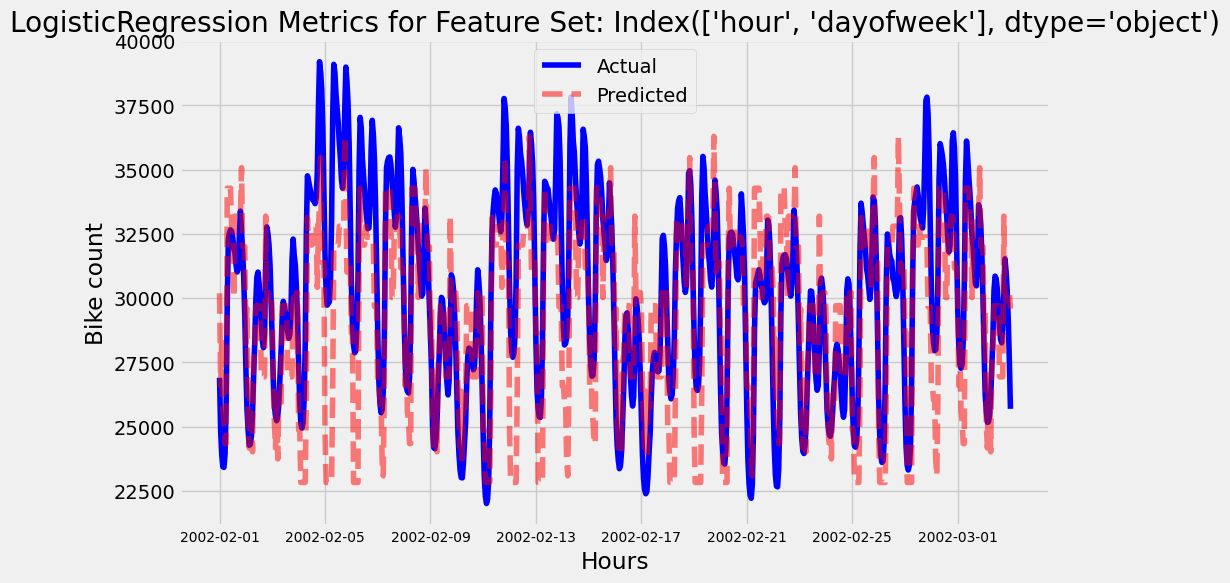

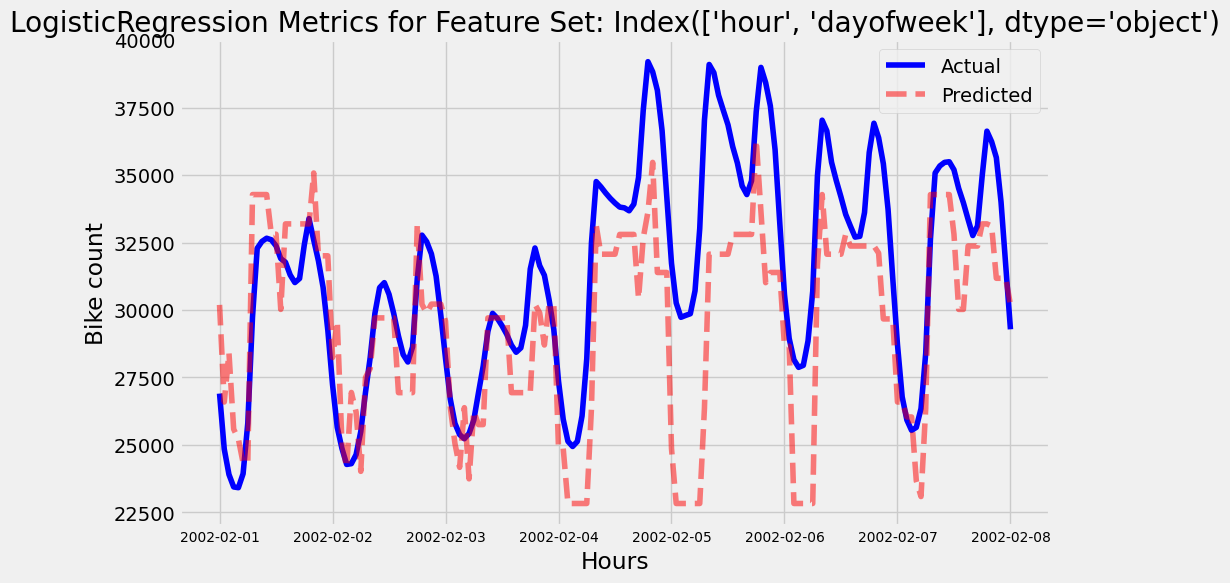

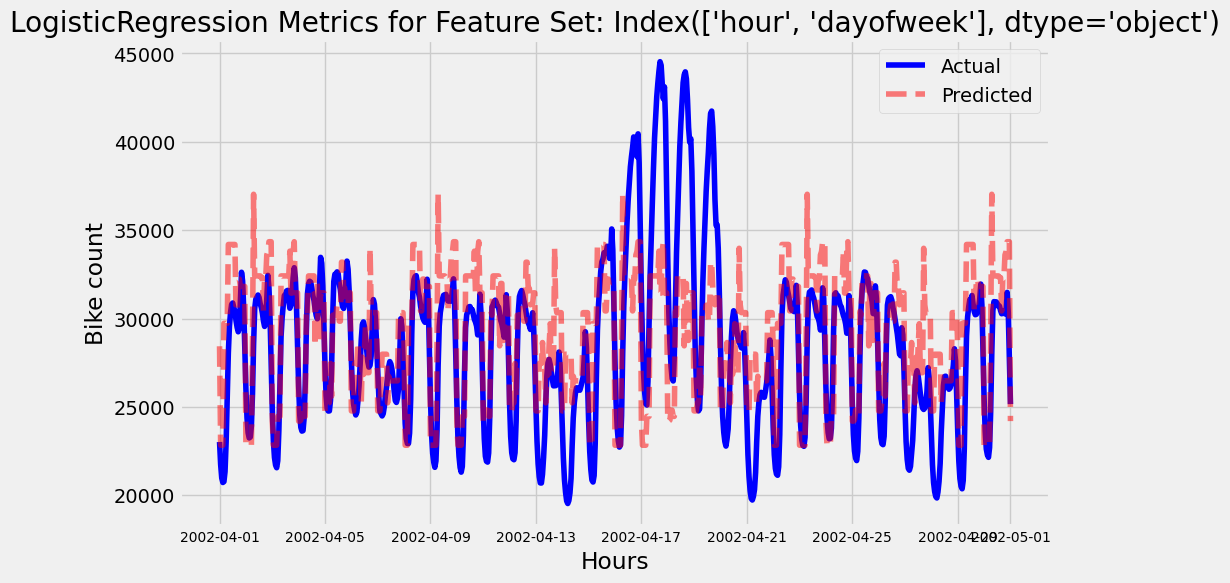

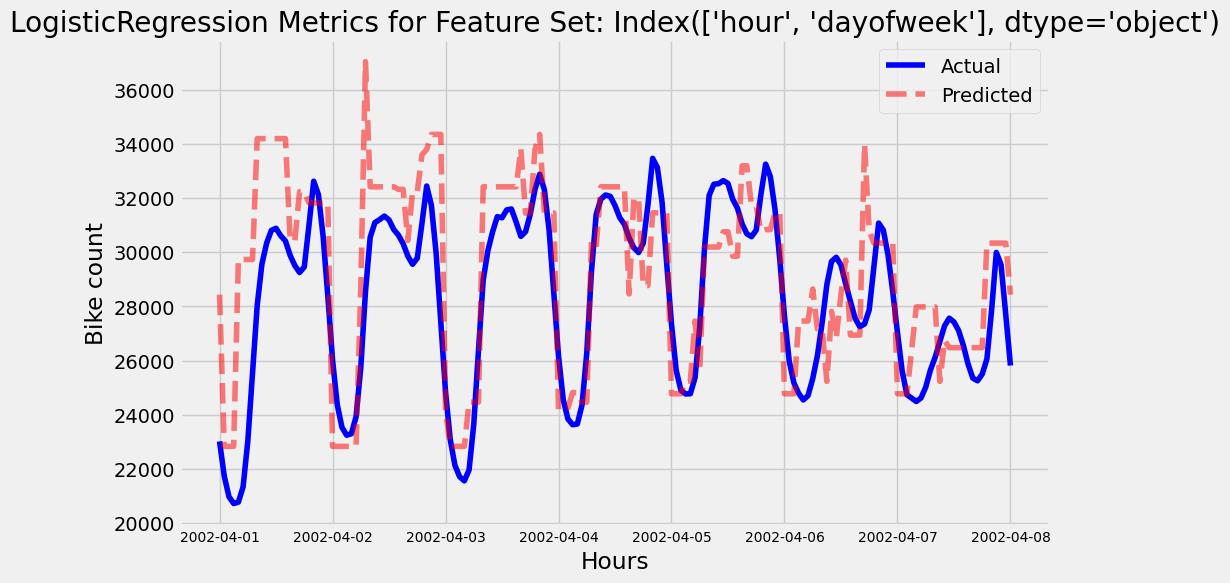

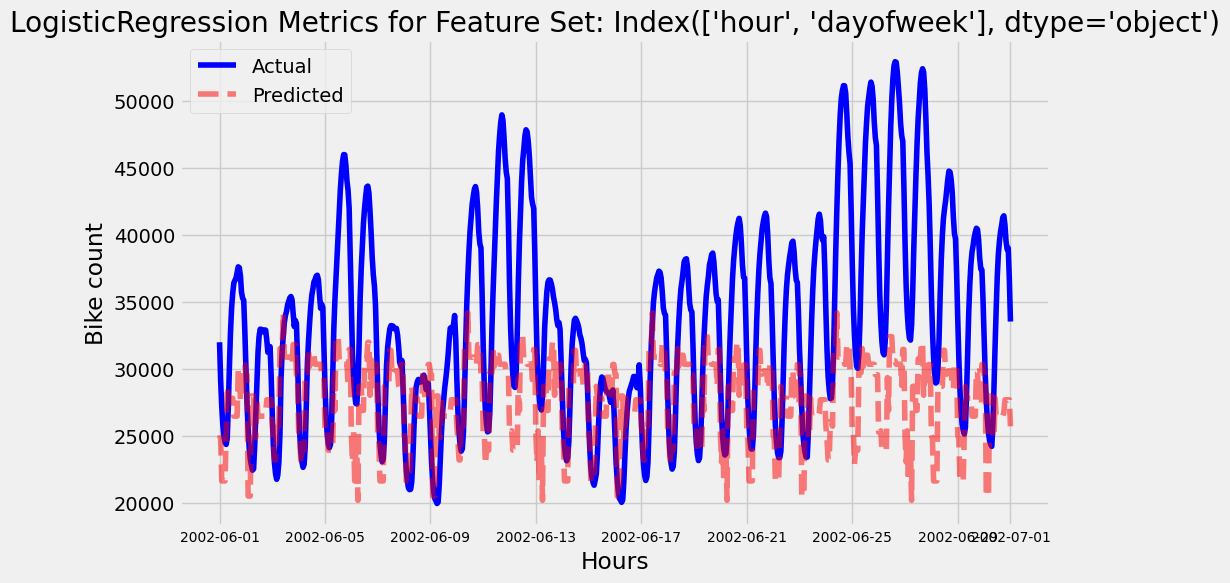

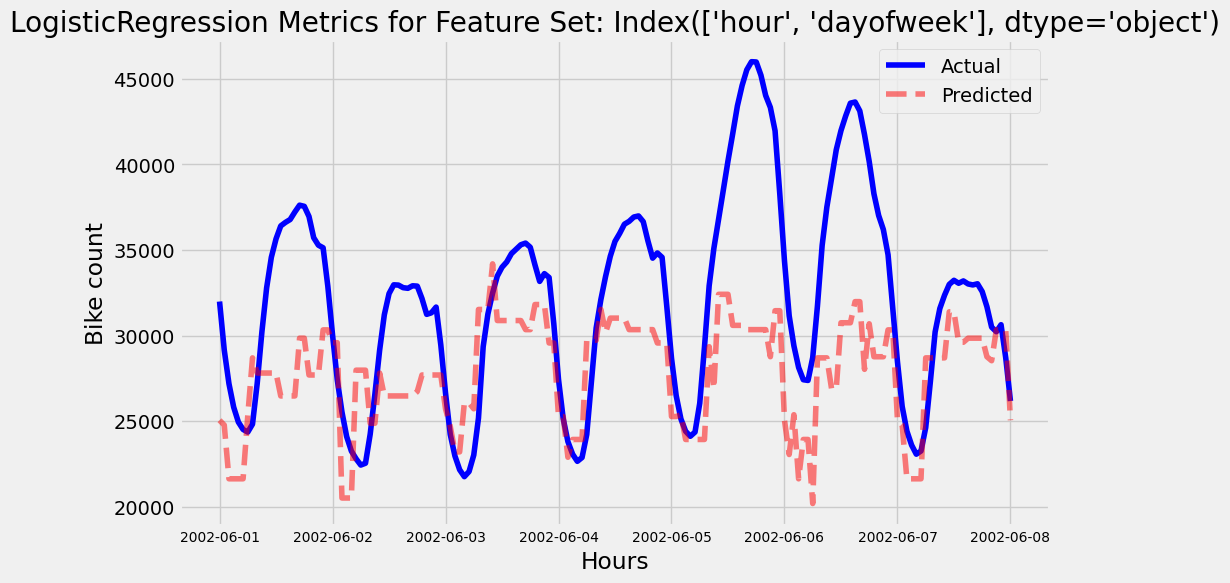

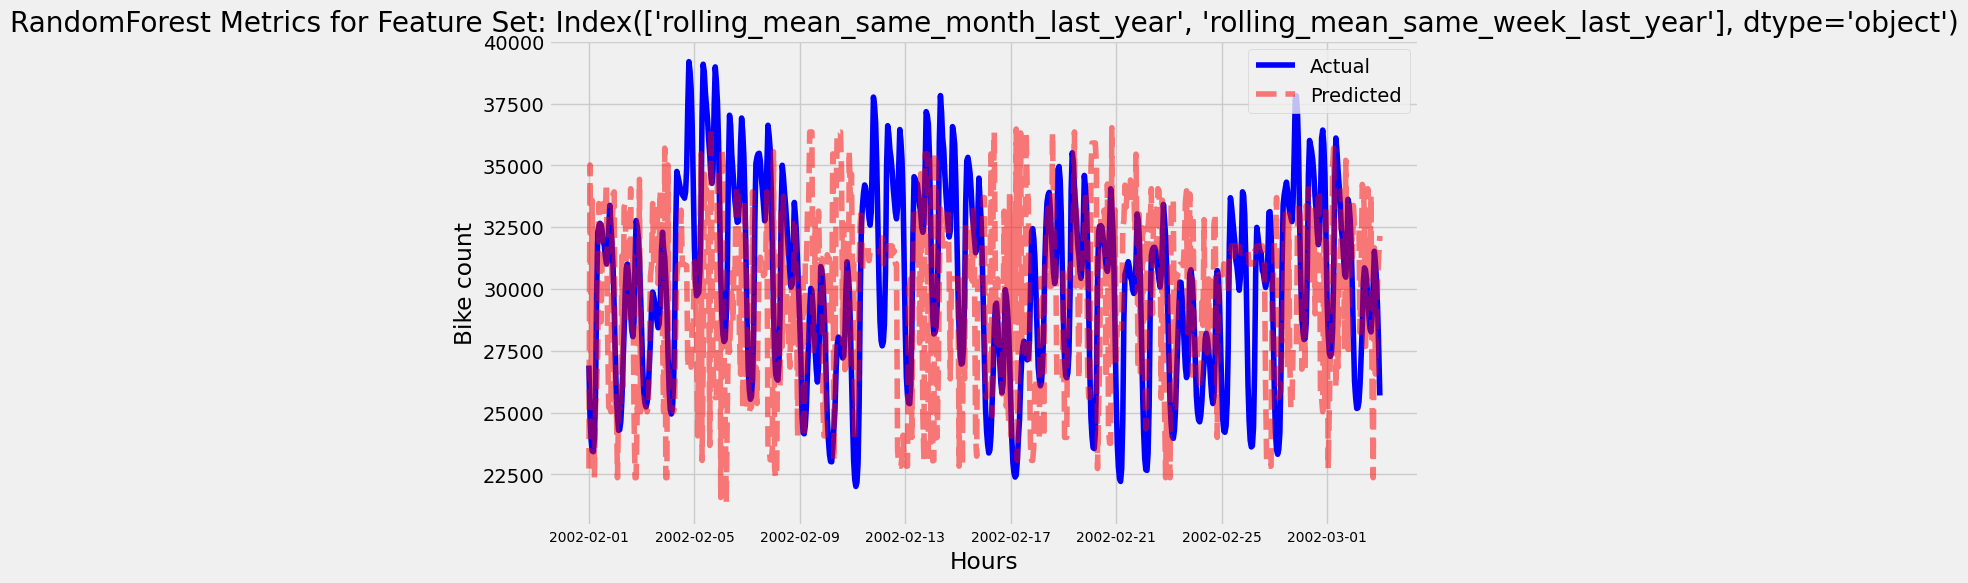

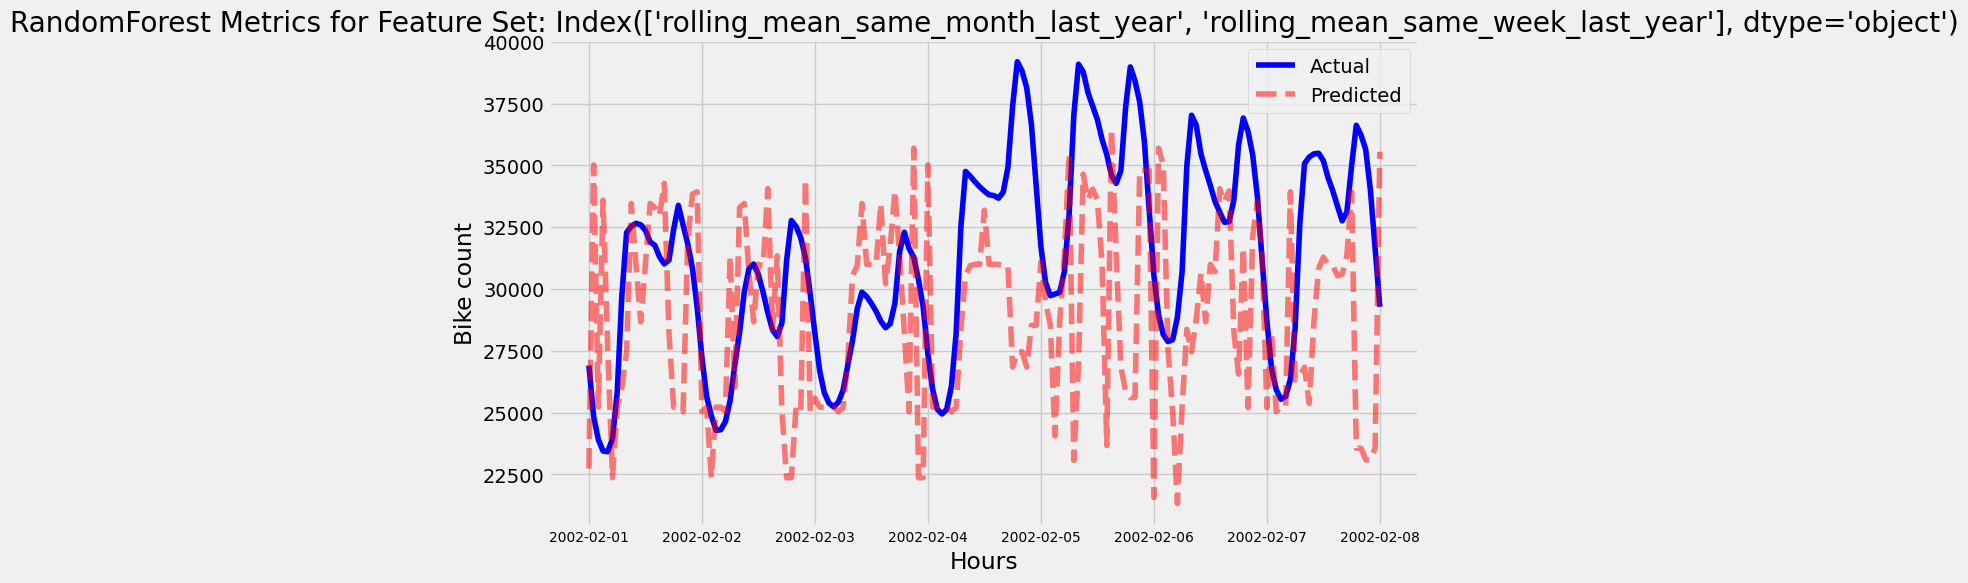

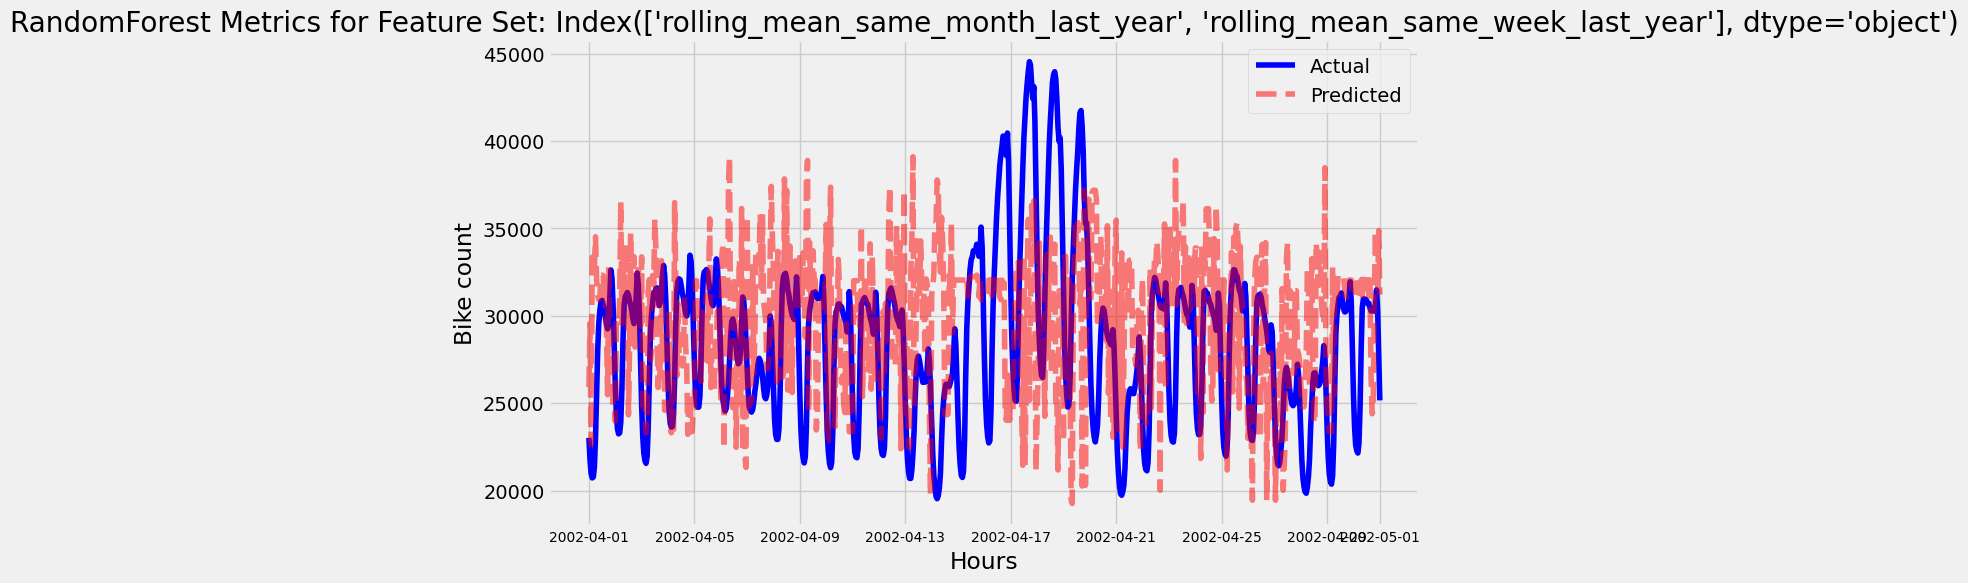

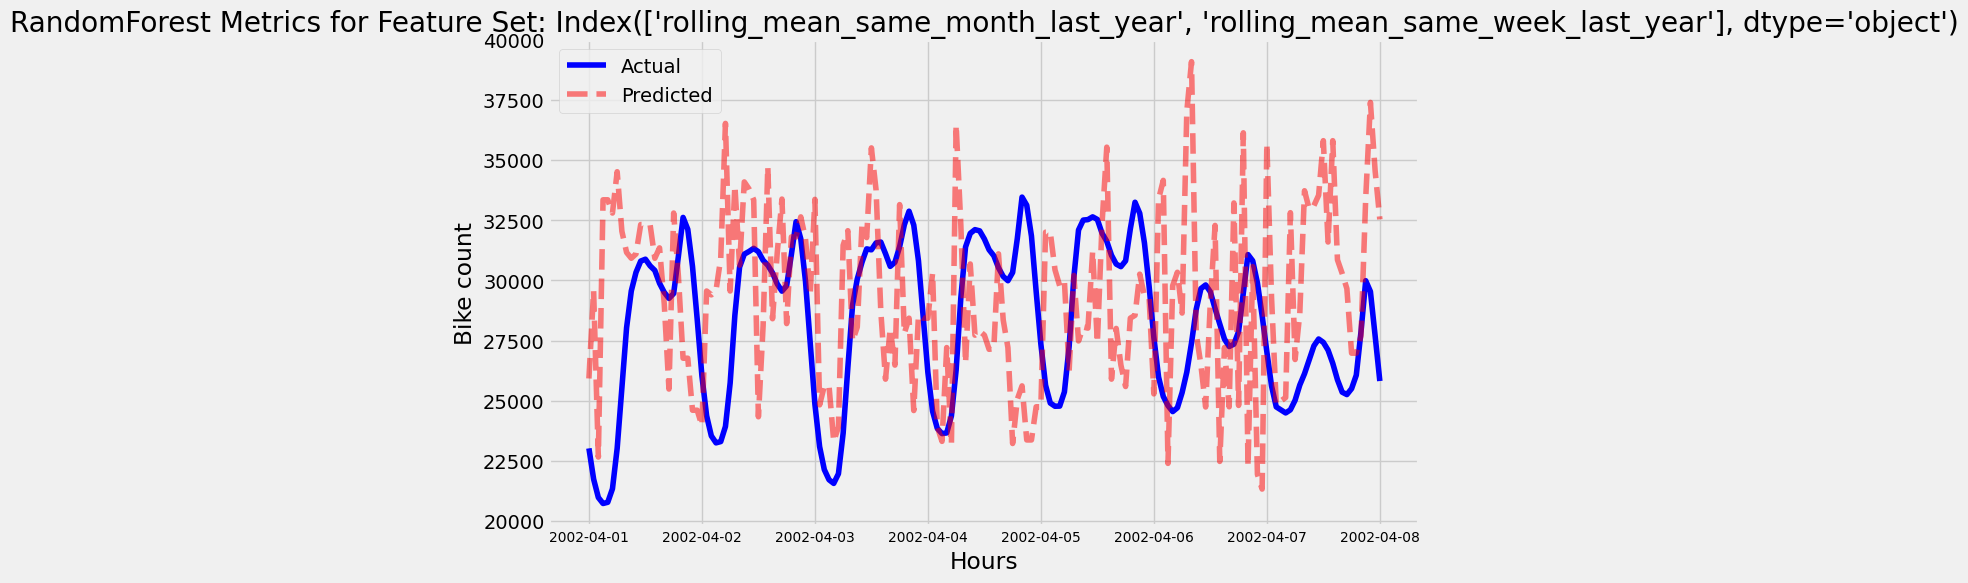

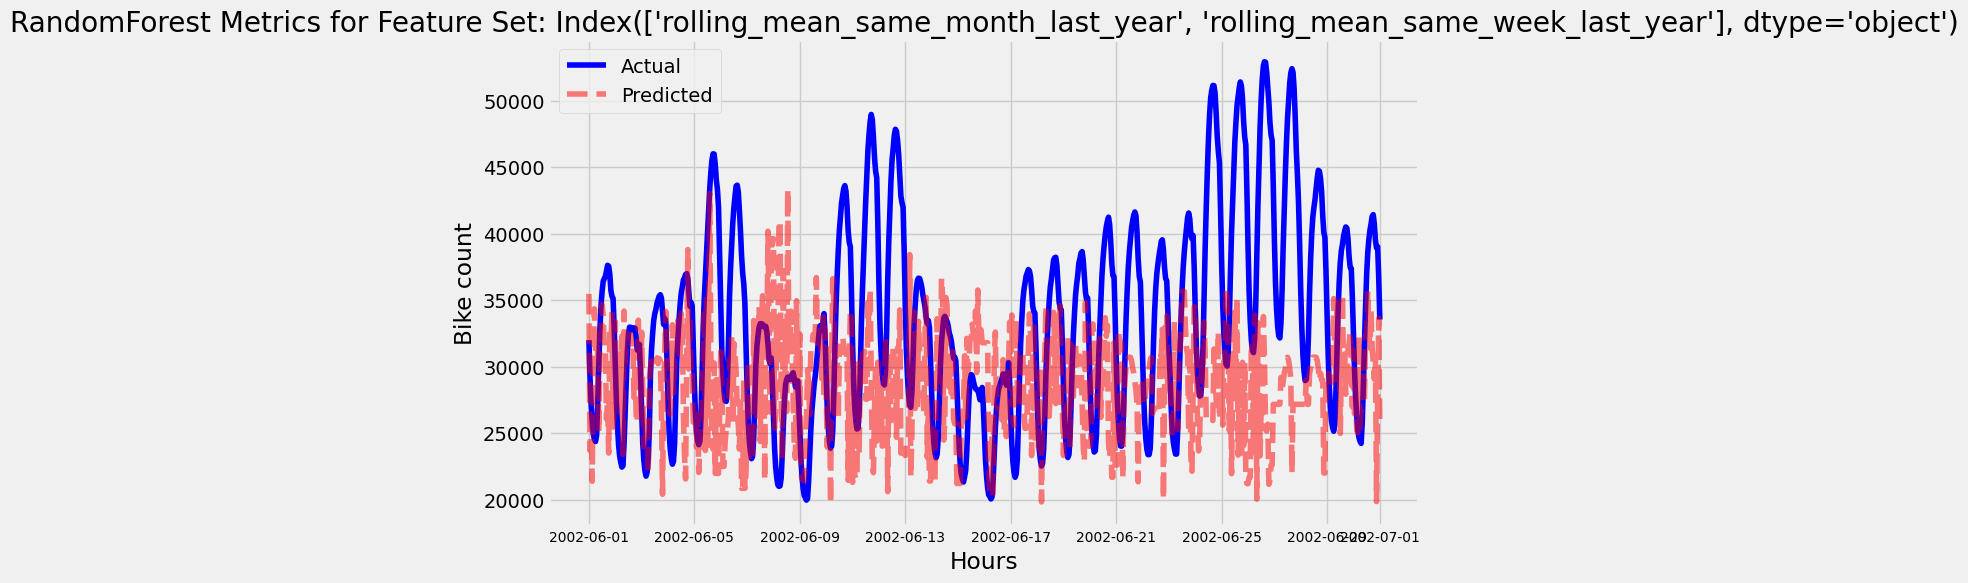

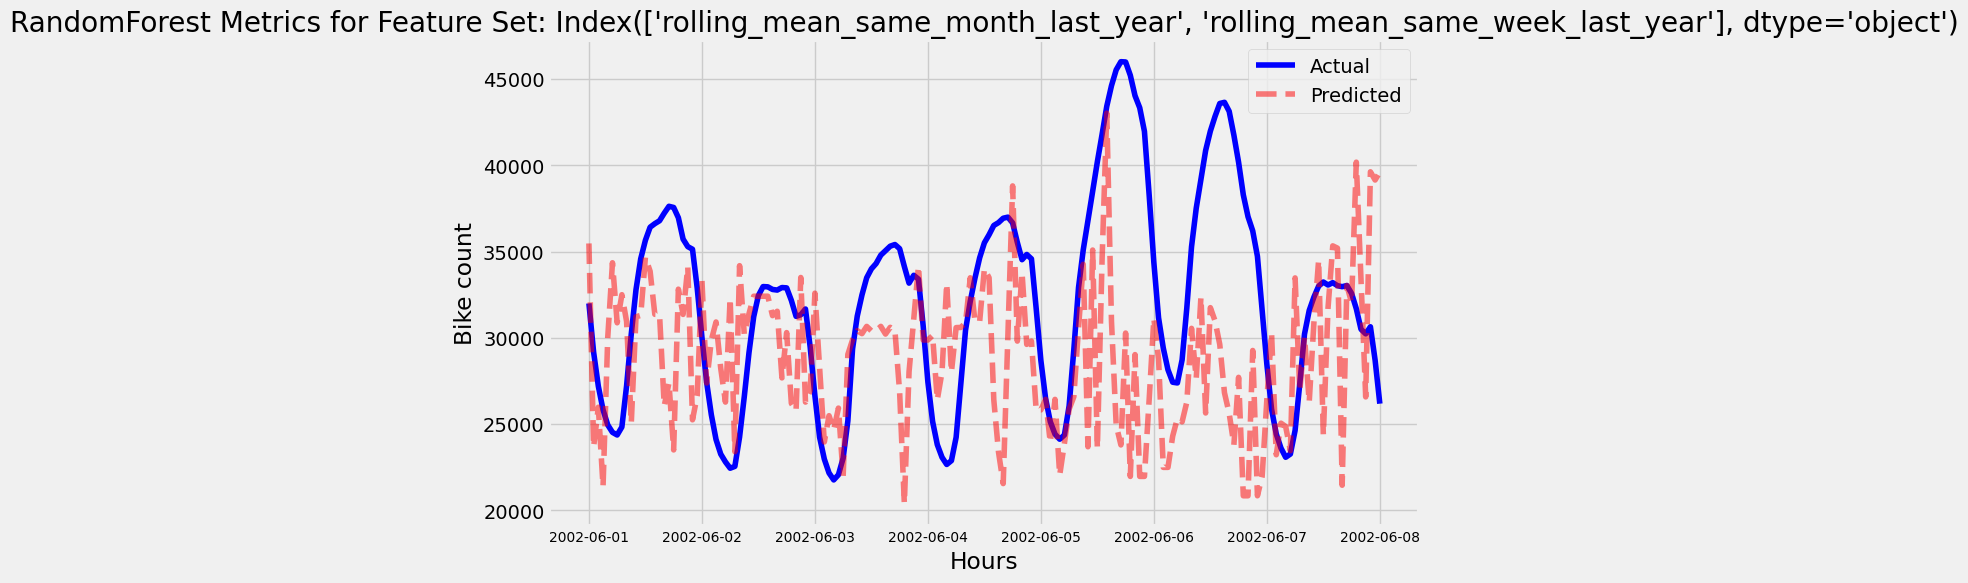

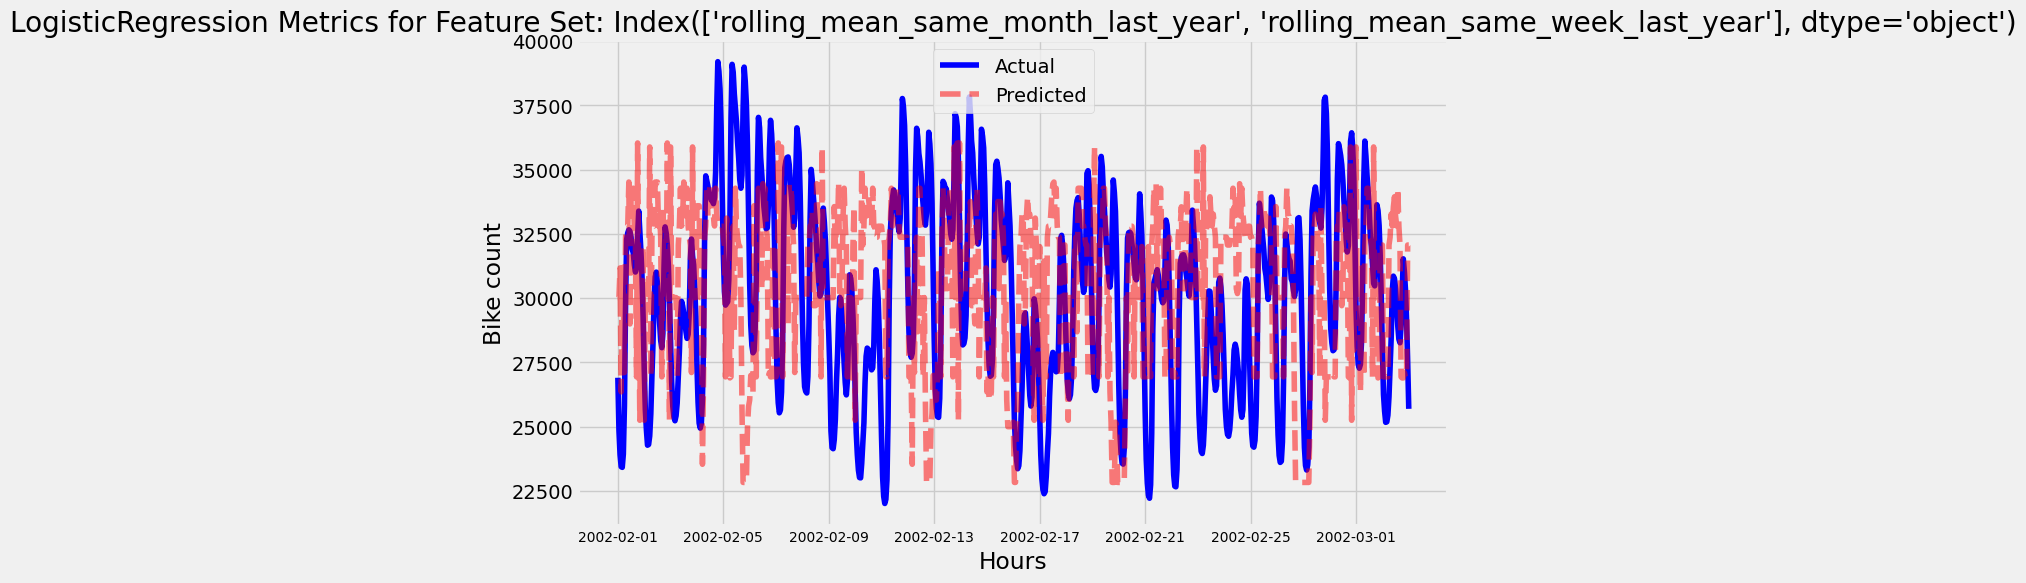

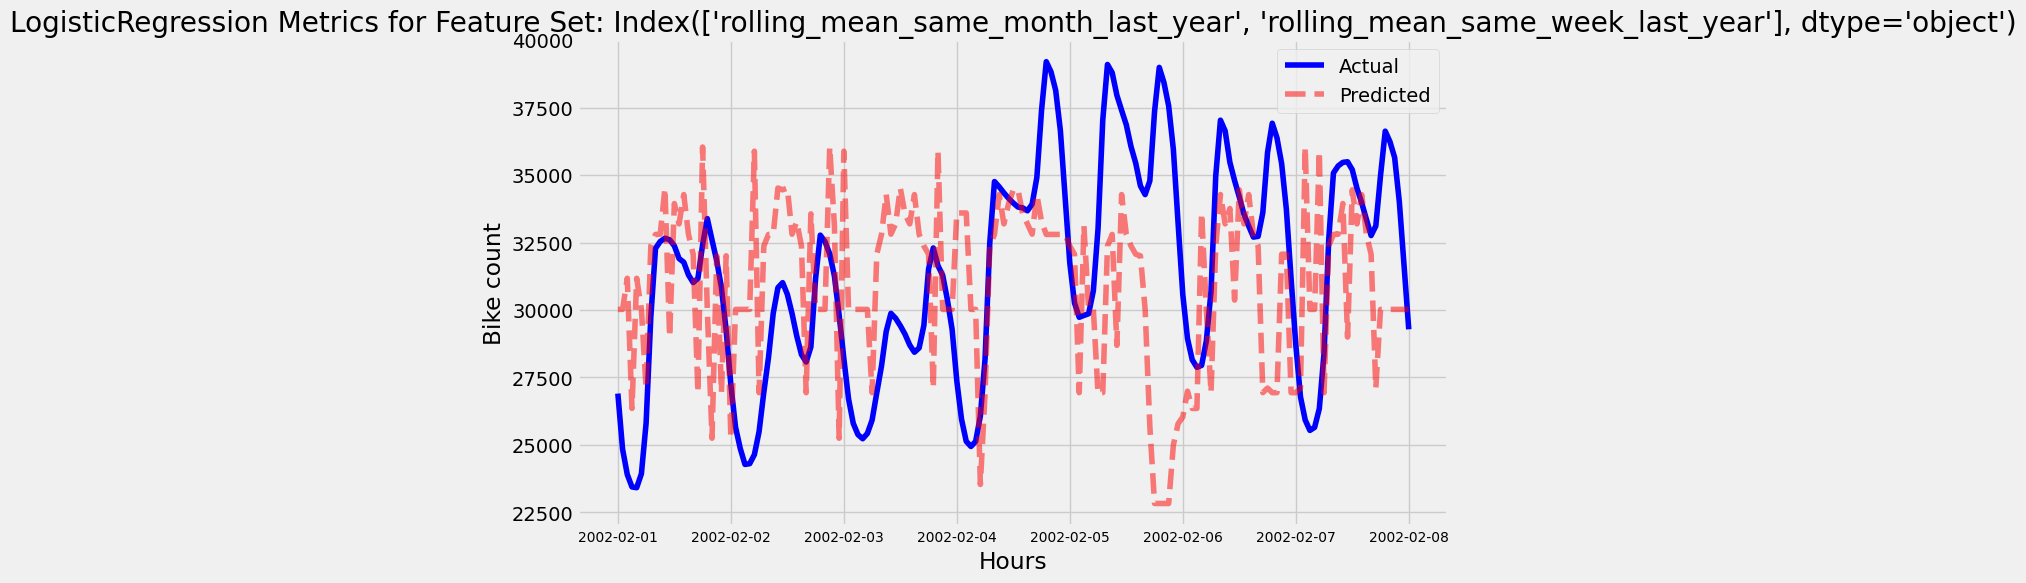

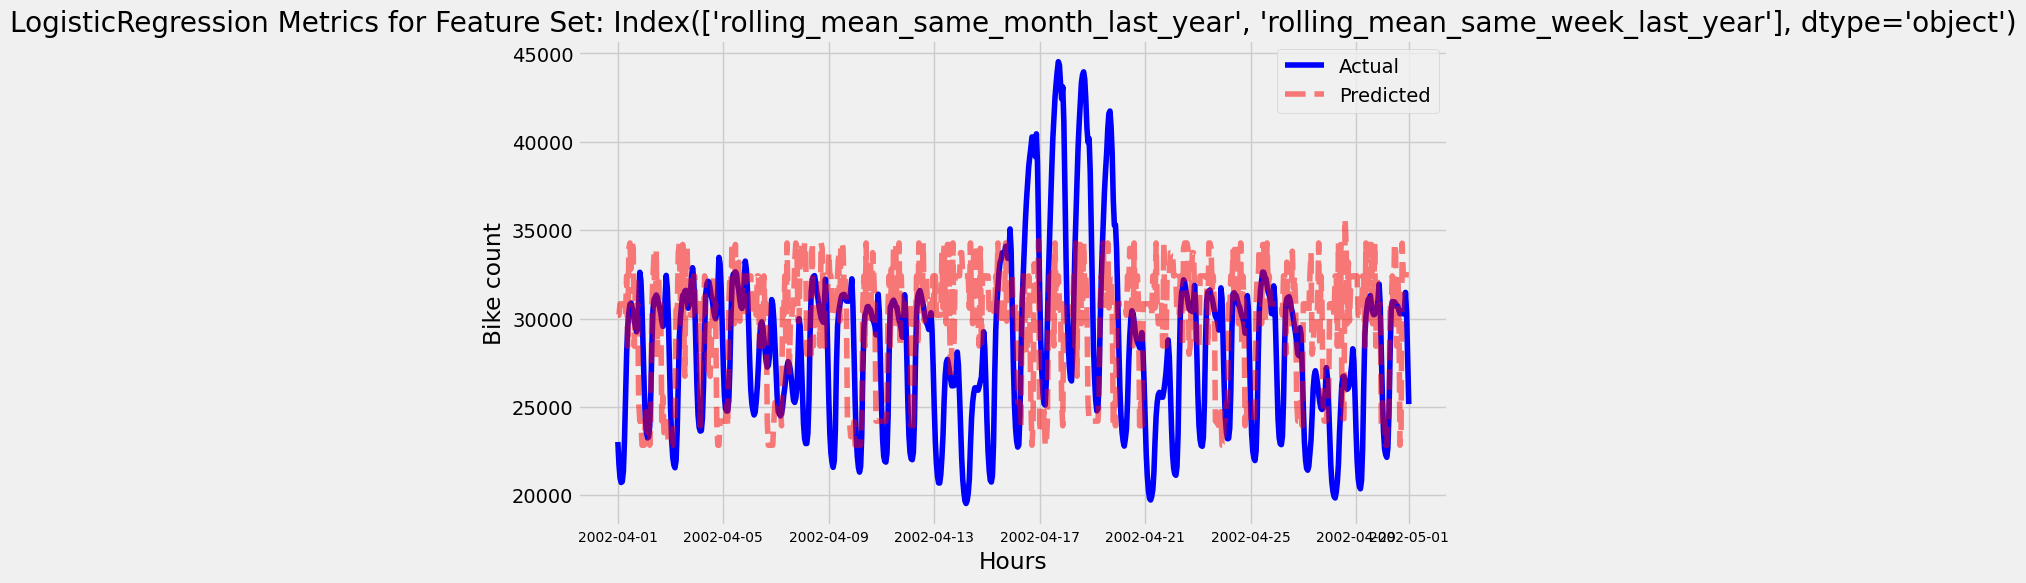

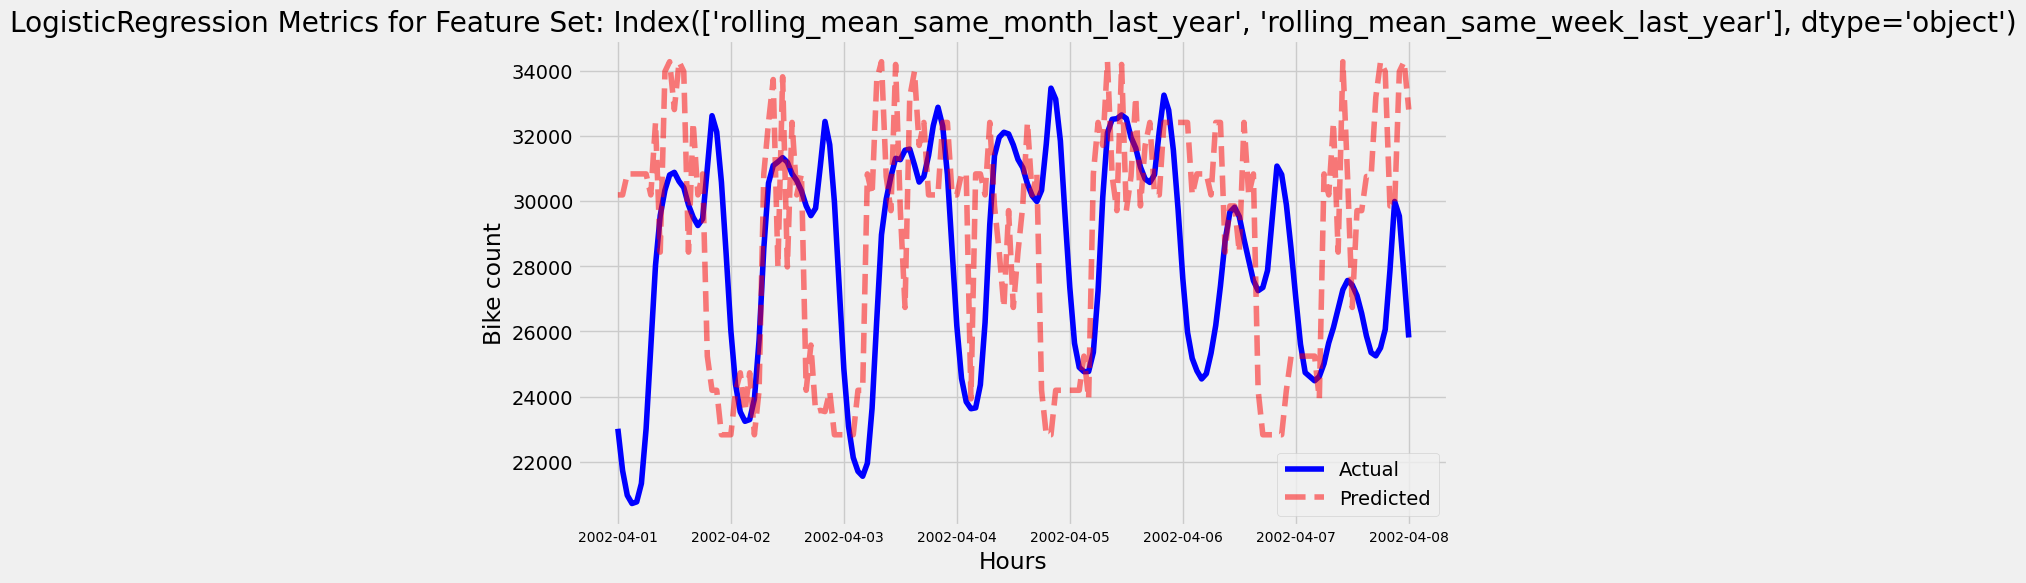

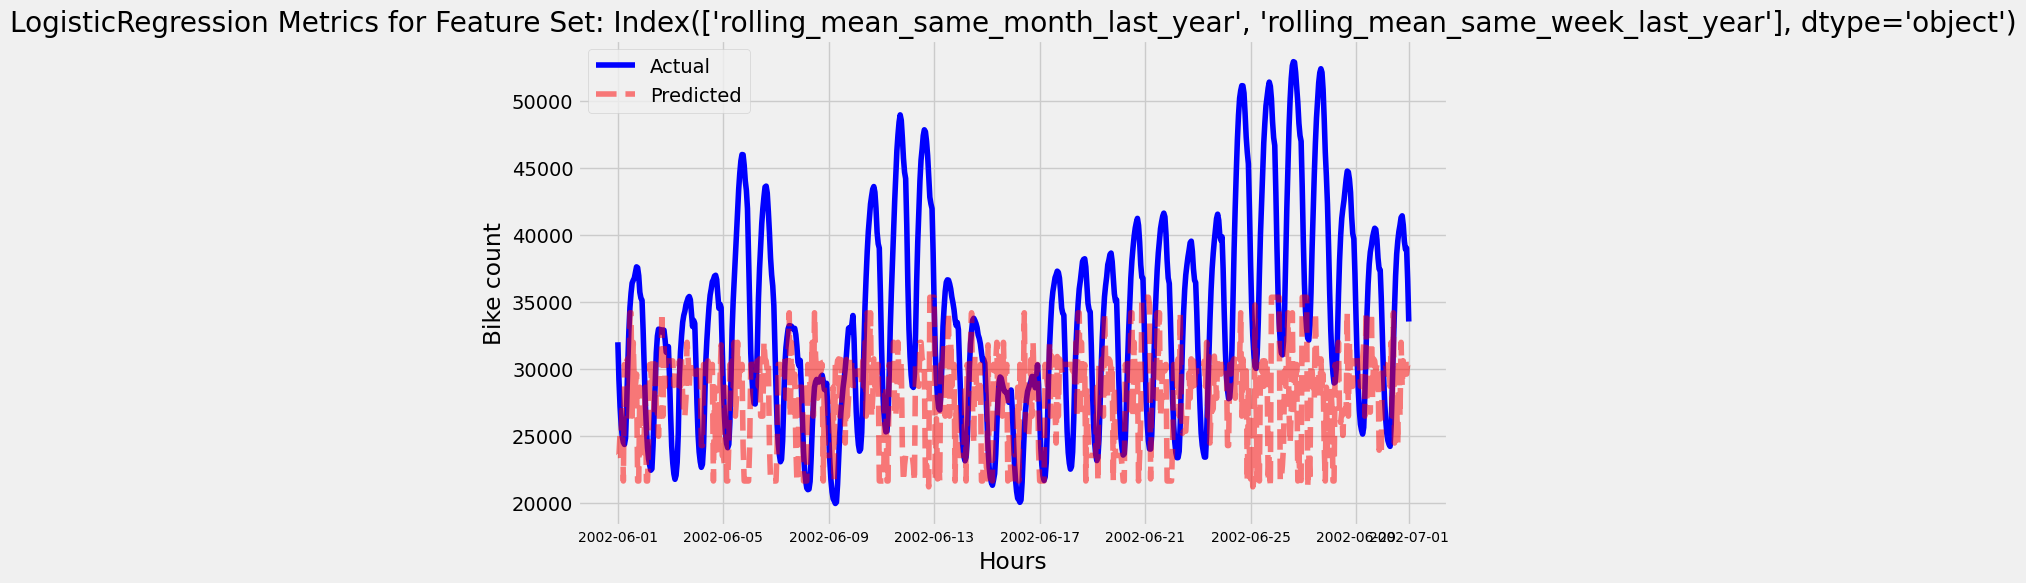

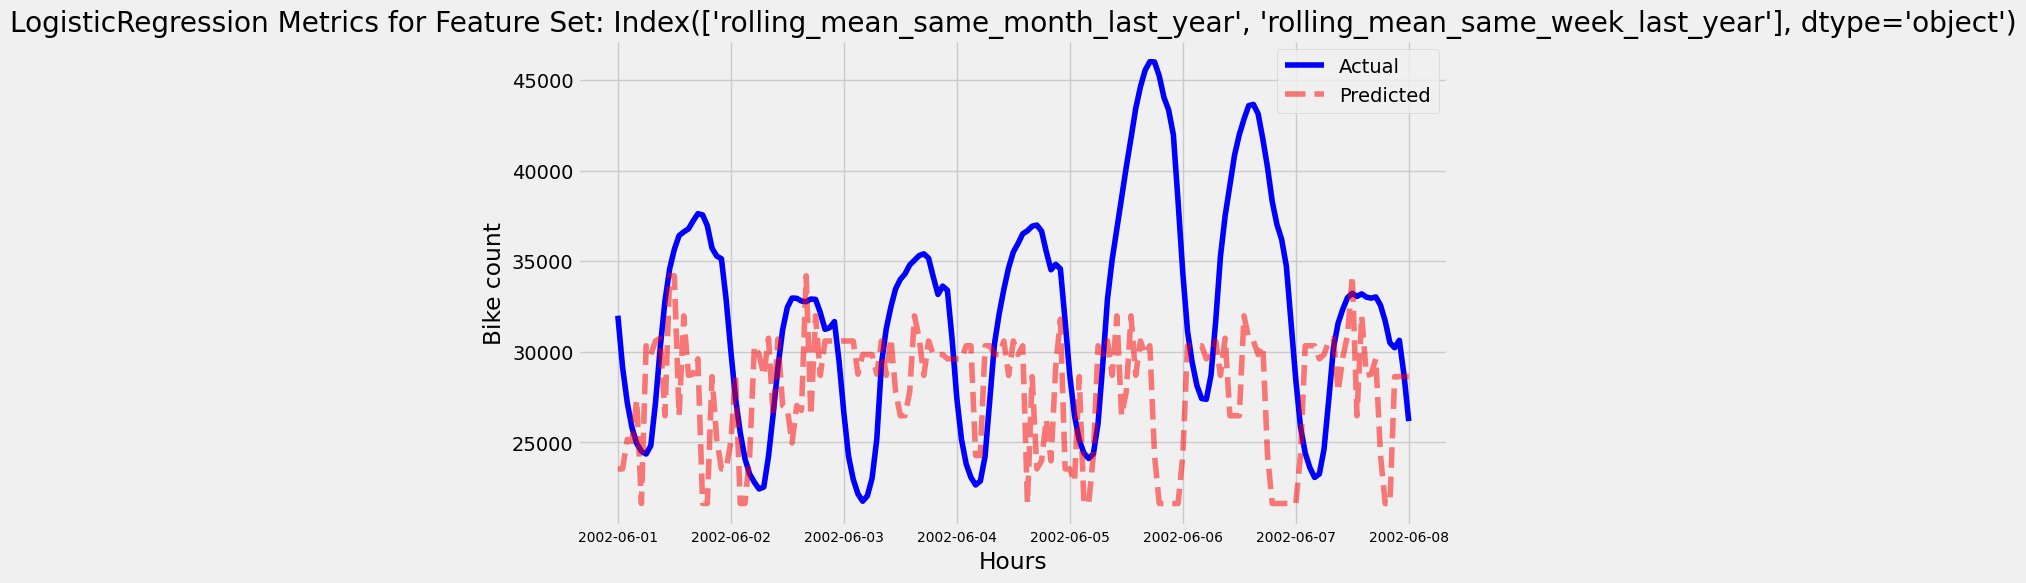

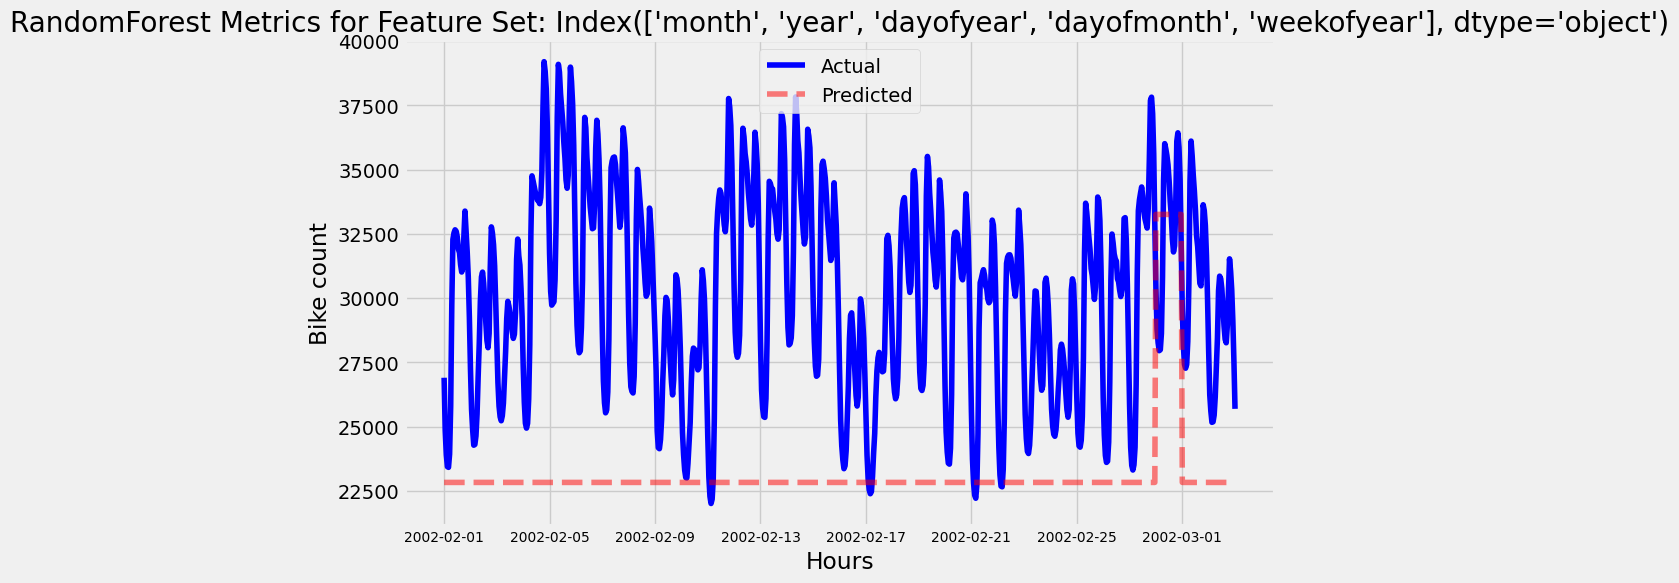

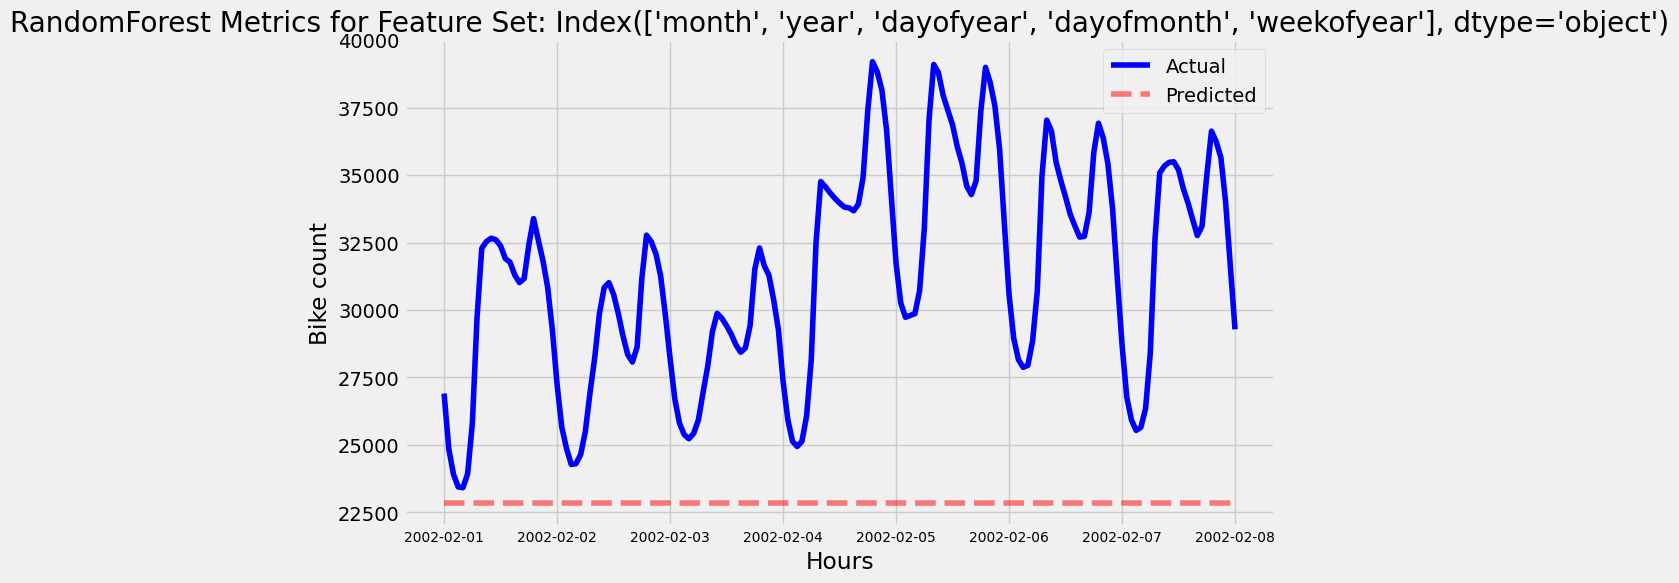

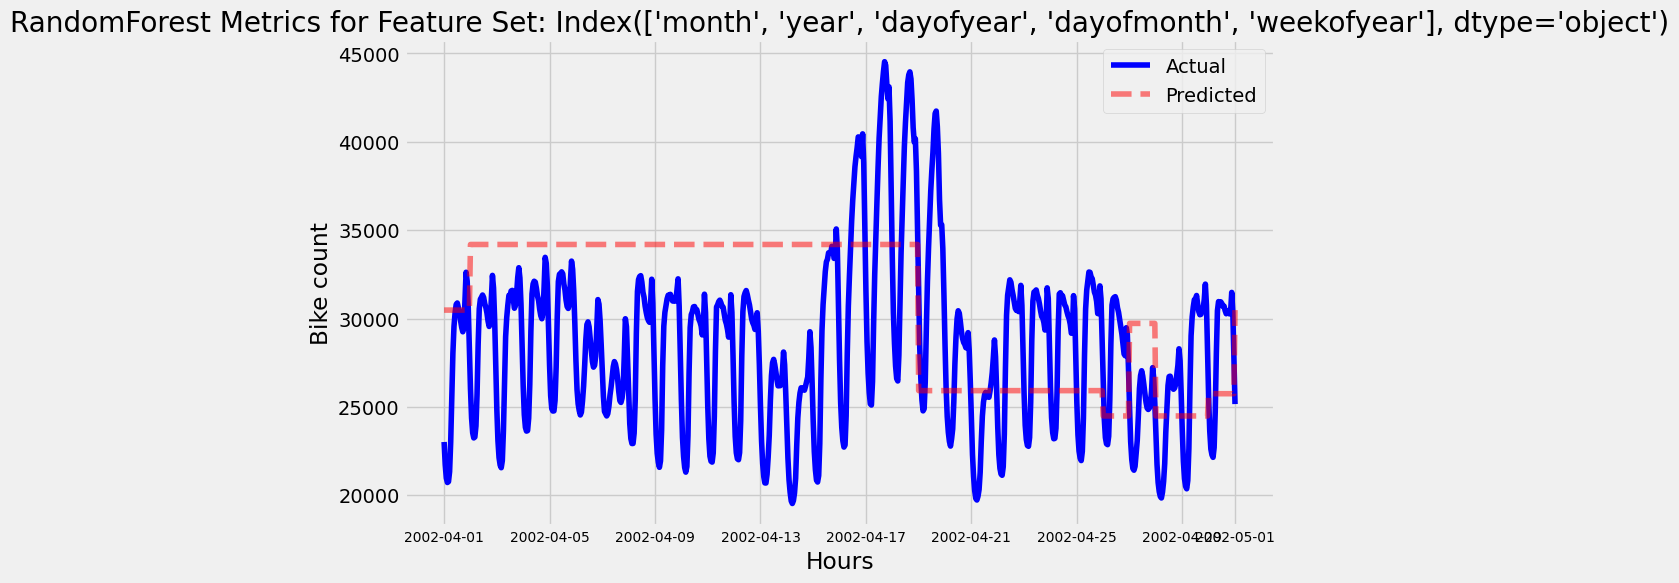

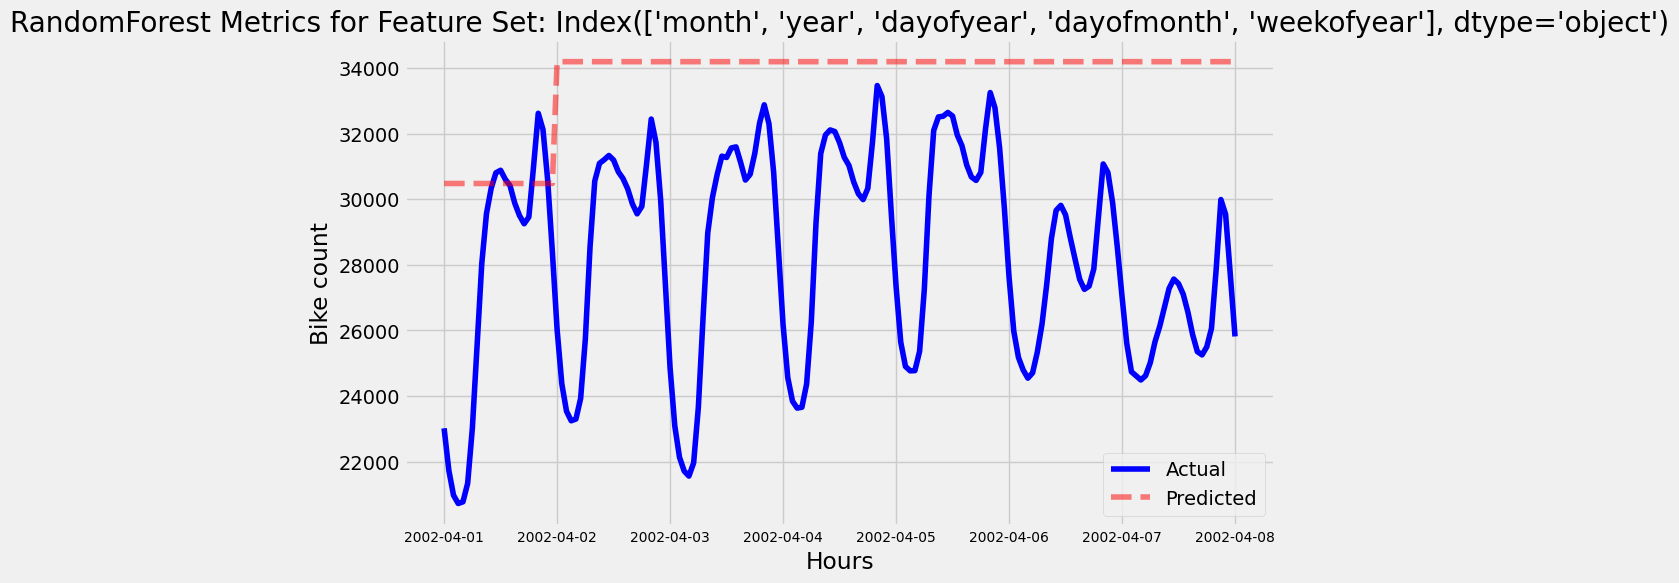

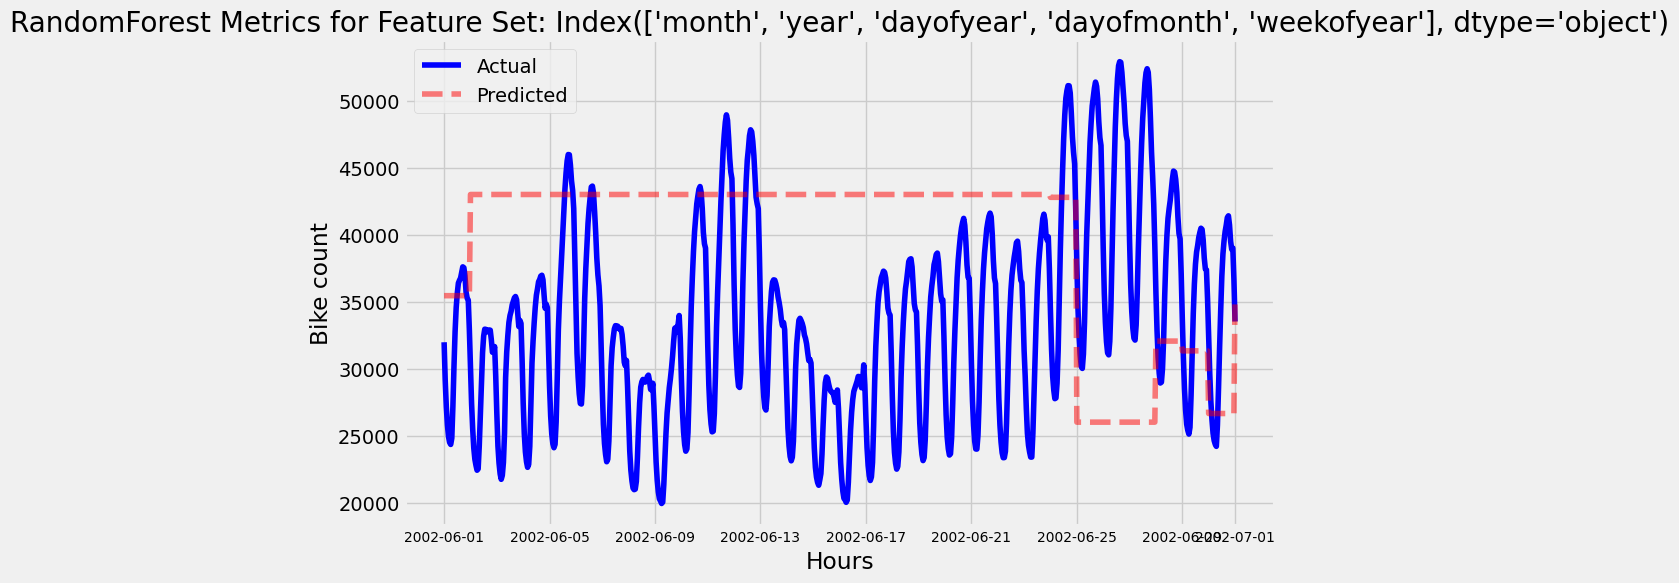

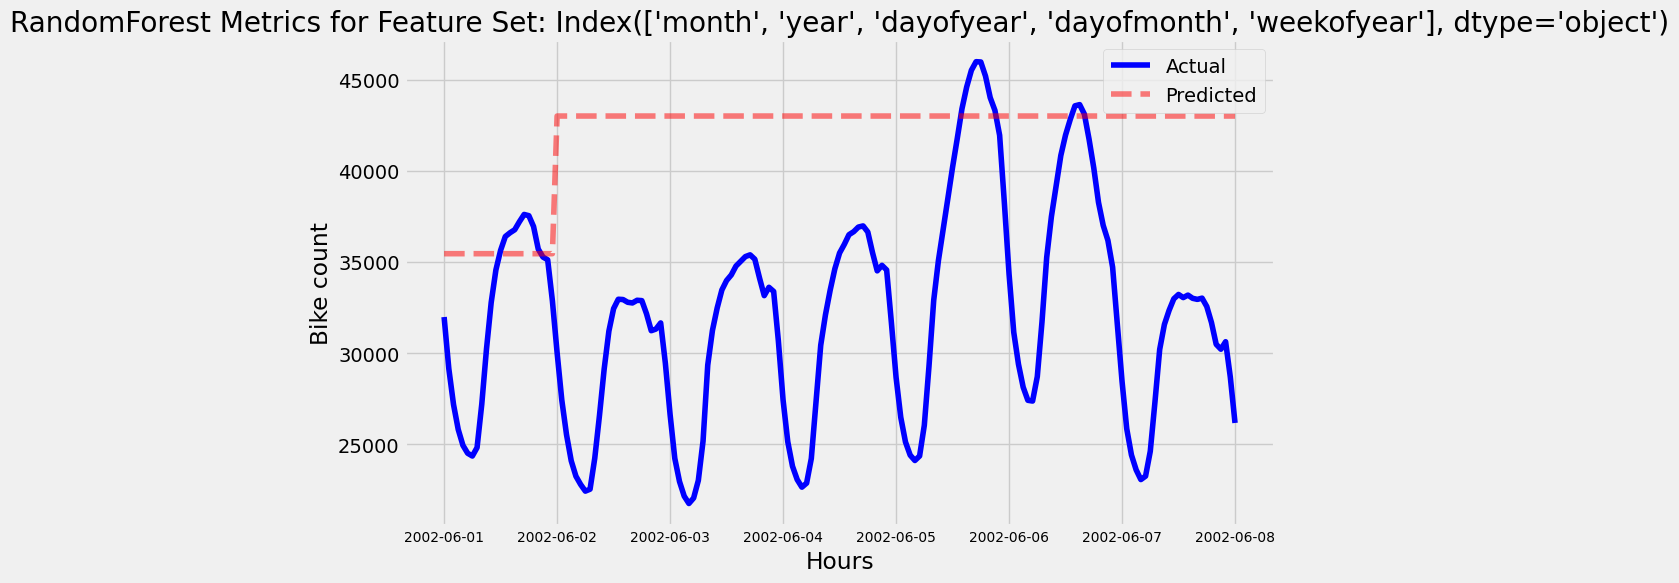

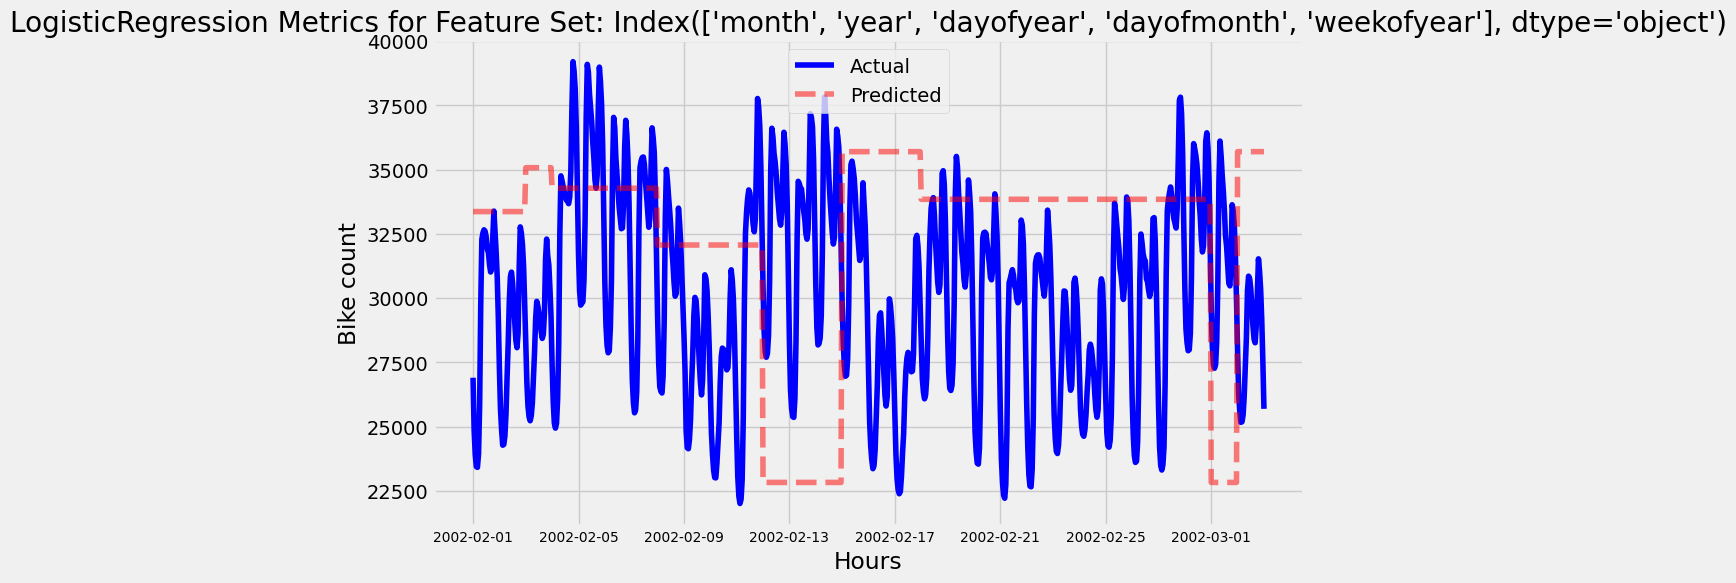

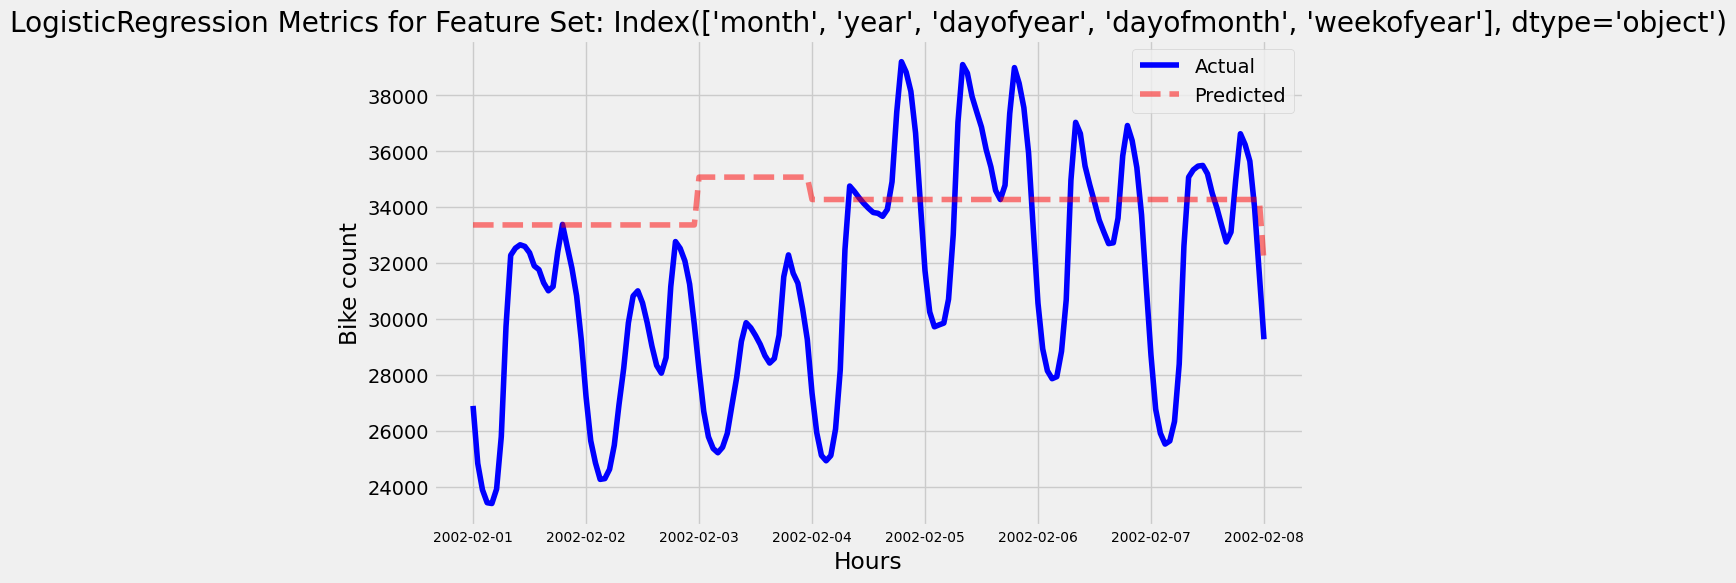

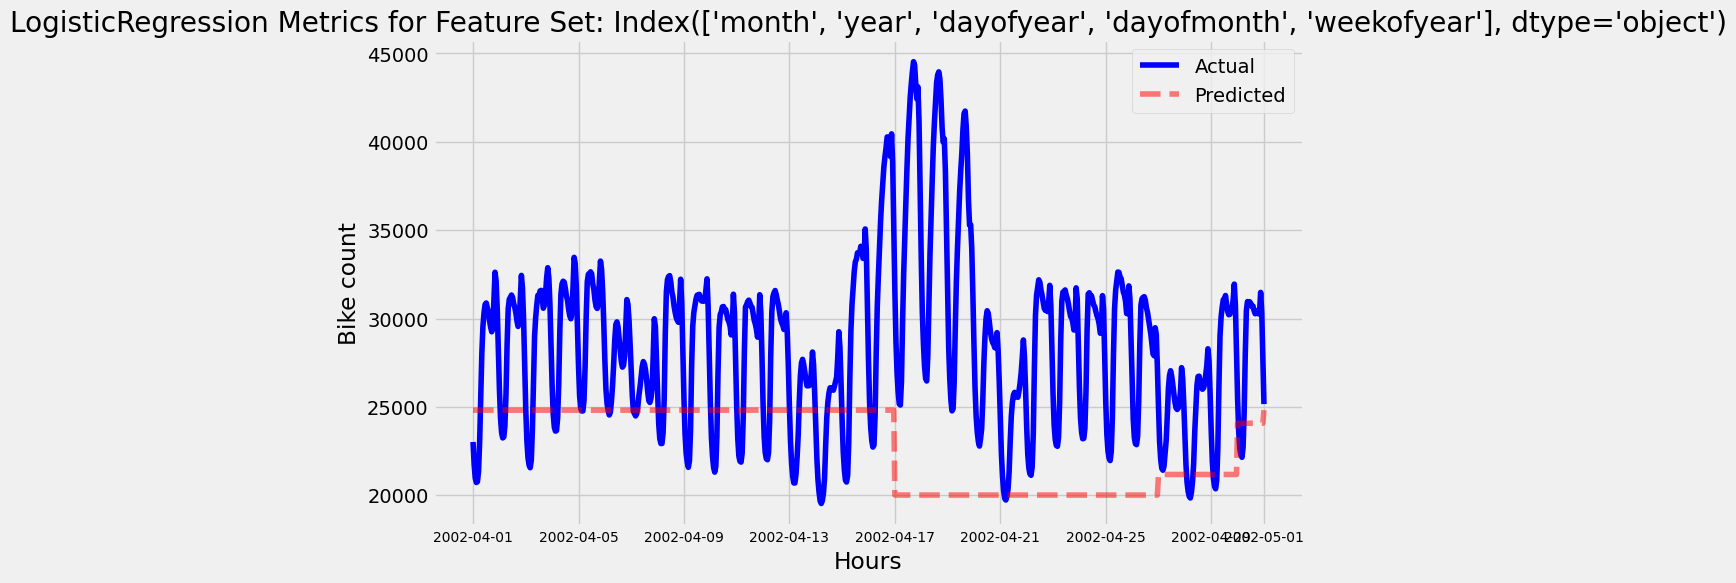

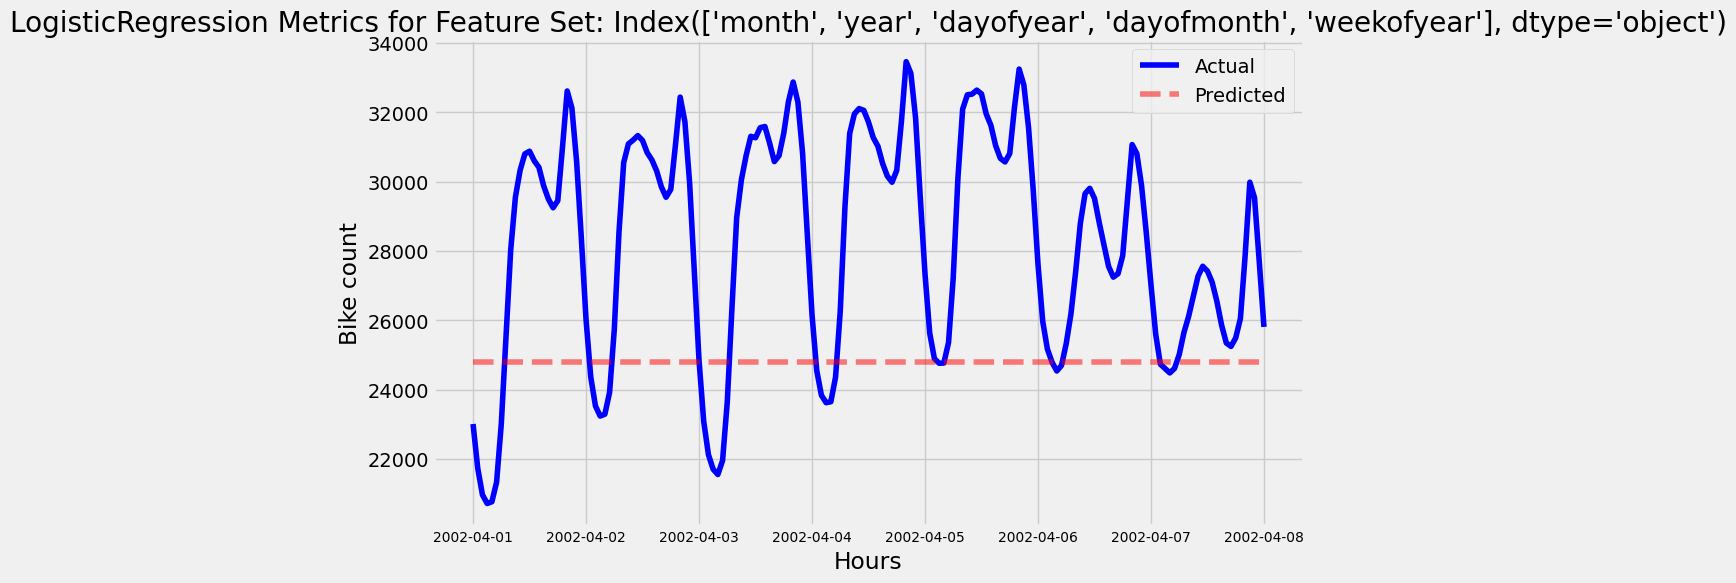

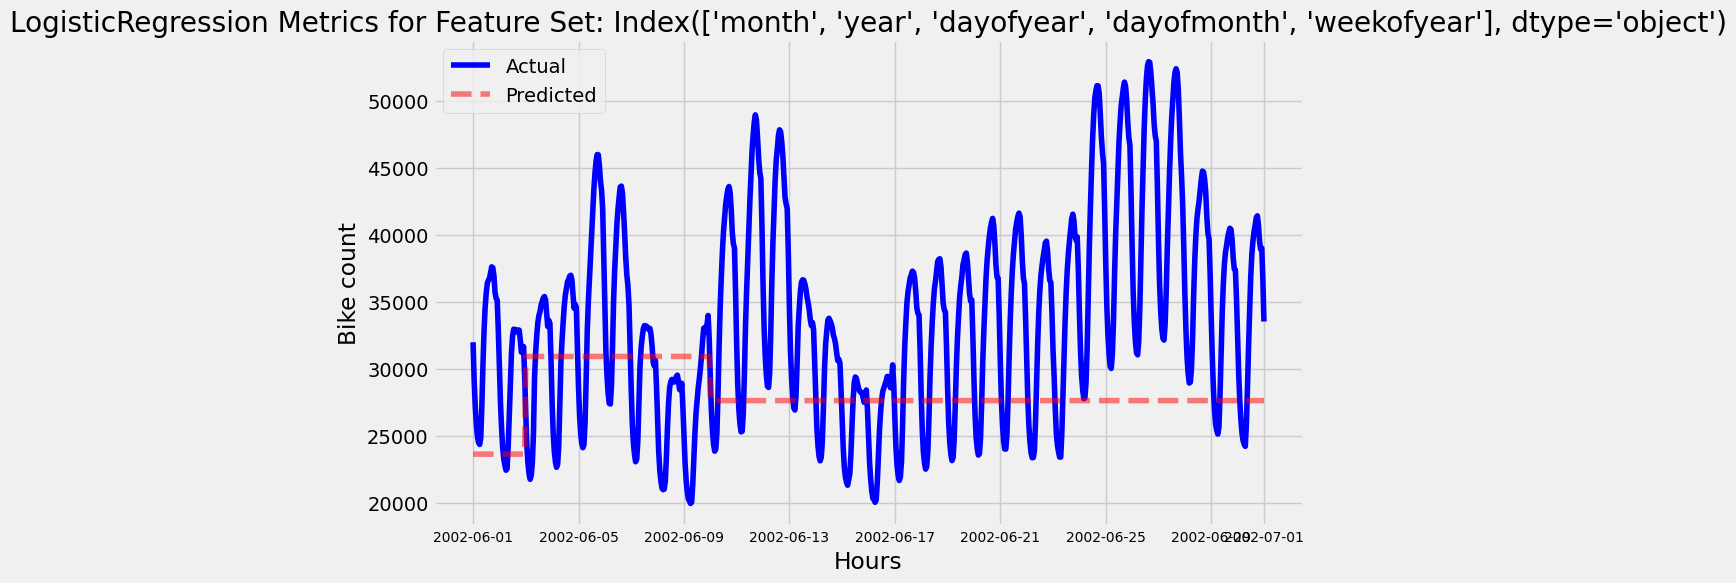

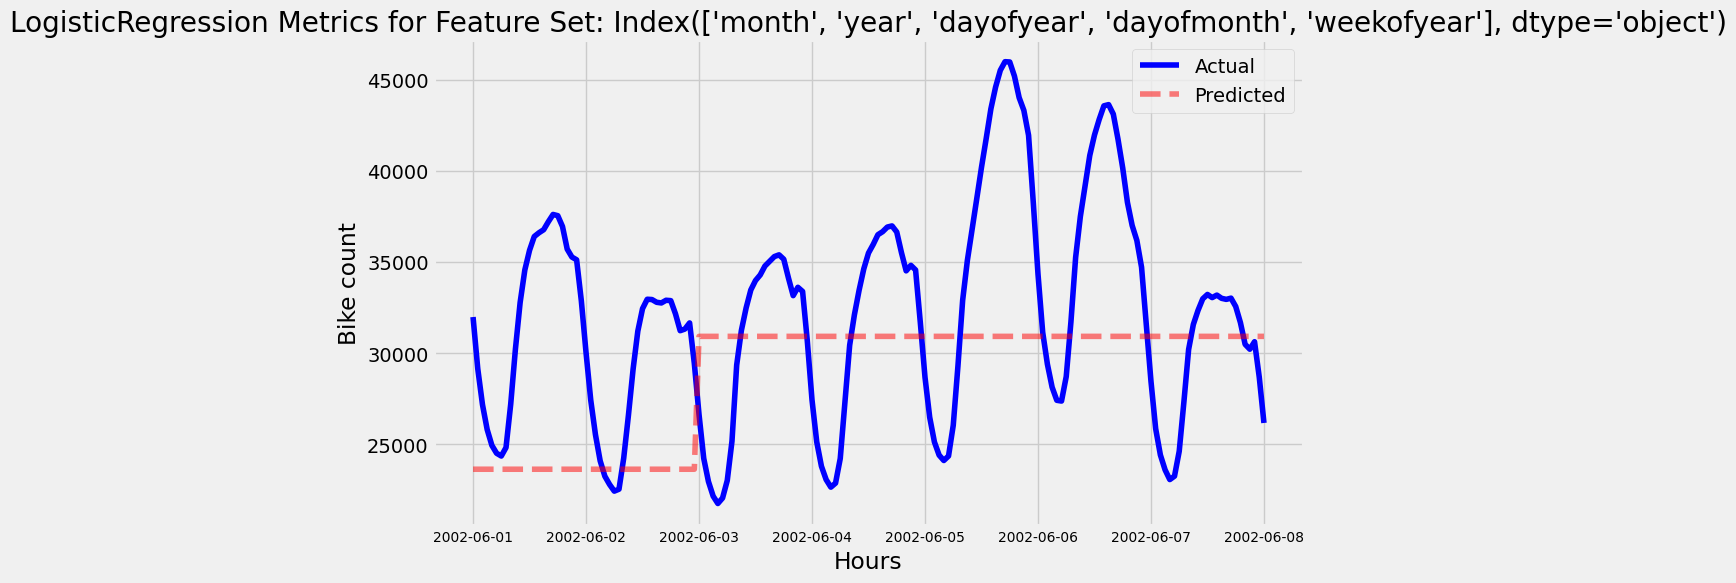

In [ ]:

# Start MLFlow experiment
mlflow.set_experiment("MLFlow Energy Consumption data")

results = []

# Train models with different feature combinations
for features in feature_combinations:
    for model_name, model in zip(["RandomForest", "LogisticRegression"],
                                 [RandomForestClassifier(random_state=42), LogisticRegression(max_iter=200)]): # just need one more, and add the hyper params, yet another loop

        for split in time_split:

            with mlflow.start_run():
                # Log feature combination and model type
                mlflow.log_param("features", features)
                mlflow.log_param("model_type", model_name)

                start_date = '02-01-2002'
                end_date = '08-01-2002'
                    
                # Train test split
                X_train = X.loc[(X.index < split)]
                y_train = y.loc[(y.index < split)]

                X_test = X.loc[(X.index >= split) & (X.index < end_date)] ## 01-01-2004
                y_test = y.loc[(y.index >= split) & (y.index < end_date)]

                # Train the model
                model.fit(X_train[features], y_train)
                predictions = model.predict(X_test[features])
                
                # Calculate metrics
                mae = mean_absolute_error(y_test, predictions)
                rmse = np.sqrt(mean_squared_error(y_test, predictions))
                
                # Log metrics
                mlflow.log_metric("precision", mae)
                mlflow.log_metric("recall", rmse)
                
                # Create and log a plot of the metrics
                # 1 month
                X_fun = X[X.index.min():(X.index.min() + pd.Timedelta(days=3))]

                y_test_month = y_test[y_test.index.min():(y_test.index.min() + pd.Timedelta(days=30))]
                predictions_month = model.predict(X_test[y_test.index.min():(y_test.index.min() + pd.Timedelta(days=30))][features]) # it WORKS

                plt = create_actual_predict_plot(y_test_month, predictions_month, model_name, features) 
        
                # Save the plot to a temporary file and log it as an artifact
                temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                plt.savefig(temp_file.name)
                mlflow.log_artifact(temp_file.name, artifact_path="plots")
                temp_file.close()

                # 1 week
                y_test_week = y_test[y_test.index.min():(y_test.index.min() + pd.Timedelta(days=7))]
                predictions_week = model.predict(X_test[y_test.index.min():(y_test.index.min() + pd.Timedelta(days=7))][features])
                #predictions_week = predictions[y_test.index.min():(y_test.index.min() + pd.Timedelta(days=7))] # old code for reference

                plt = create_actual_predict_plot(y_test_week, predictions_week, model_name, features) 
        
                # Save the plot to a temporary file and log it as an artifact
                temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                plt.savefig(temp_file.name)
                mlflow.log_artifact(temp_file.name, artifact_path="plots")
                temp_file.close()
                
                # Log the model
                mlflow.sklearn.log_model(model, model_name)
                mlflow.log_param("train split", (str(X_train.index.min()) + "---" + str(X_train.index.max())))
                mlflow.log_param("test split", (str(X_test.index.min()) + "---" + str(X_test.index.max())))
                
                # Store results for summary
                results.append({
                    "features": features,
                    "model": model_name,
                    "MAE": mae,
                    "RMSE": rmse
                })

# Print summary of results
results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)

### 3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used

#### 4. Turn on MLFlow UI and track your experiments